# Avian Disease Prediction Analysis based on Government dashboard and external resources

This study will focus on using data from Death counts, 6 diagnosis: including Egg Peritonitis & Salpingiti, Colisepticaemia Yolk sac infection/ omphalitis, Broiler ascites, Red Mite, Marek's Disease and other resources such as weather, temperature, etc. based on regions to detect early case of outbreaks of Avian Disease on poultry and suggest prevention methods based on these findings.

Avian Disease dashboard: https://public.tableau.com/app/profile/siu.apha/viz/AvianDashboard/Overview

## Feature Engineering

### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

### Creating new features

In [2]:
# Read the collected dataset
df = pd.read_excel ('AvianDataset.xlsx', sheet_name = 'Number')

# Replace \n with a space for clearer column names
pd.set_option('display.max_colwidth', None)
df.columns = df.columns.str.replace('\n', ' ')
df

,No.,Month,Year,0-7 days,Immature,Adult,Scotland,East of England,South West,Wales,...,Min_temp South East,Days of frost South East,Hours of rainfall South East,Hours of sunshine South East,Precipitation Scotland,Precipitation Southwest,Precipitation Wales,Precipitation West Midlands,Precipitation South East,Total death
0,1,1,2012,0,0,3,0,2,0,0,...,2.8,8.4,48.7,73.2,156.2,84.1,92.3,41.9,49.7,3
1,2,2,2012,0,1,2,2,0,0,0,...,0.3,14.5,19.3,83.7,81.0,40.6,46.1,20.5,19.9,3
2,3,3,2012,0,0,2,0,0,0,2,...,3.3,2.3,26.6,174.5,43.5,31.3,23.0,30.8,27.9,2
3,4,4,2012,0,1,3,0,0,0,0,...,3.4,4.4,133.8,155.7,124.1,153.7,98.8,125.4,130.0,4
4,5,5,2012,0,2,0,0,0,0,0,...,8.1,0.0,42.7,191.6,78.1,51.2,59.5,44.9,41.6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,8,2024,0,0,2,0,2,0,0,...,13.0,0.0,41.0,209.2,176.3,53.4,87.3,23.7,32.8,2
152,153,9,2024,0,1,1,1,0,0,0,...,10.6,0.0,157.4,129.8,91.1,168.7,146.2,122.1,141.3,2
153,154,10,2024,0,0,2,0,0,0,2,...,8.4,0.1,91.2,88.0,117.1,124.5,104.5,61.1,79.7,2
154,155,11,2024,0,0,0,0,0,0,0,...,5.0,5.7,87.9,54.0,77.1,122.2,69.2,51.4,73.5,0


In [3]:
# Create a copy of current dataset for feature engineering

df2 = df.copy()

#### Sinusoidal encoding

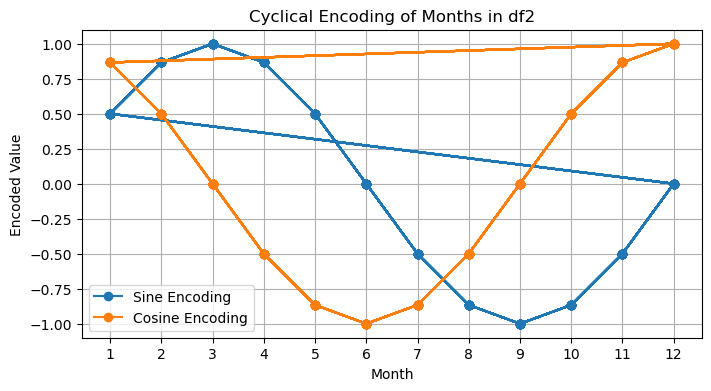

                Month_sin     Month_cos  Total death
Month_sin    1.000000e+00 -1.303138e-17    -0.250631
Month_cos   -1.303138e-17  1.000000e+00    -0.182153
Total death -2.506313e-01 -1.821526e-01     1.000000


In [4]:
# Encode using the sine/cosine to implement month cyclical encoding

df2['Month_sin'] = np.sin(2 * np.pi * df2['Month'] / 12)
df2['Month_cos'] = np.cos(2 * np.pi * df2['Month'] / 12)

# Plot sine and cosine encodings
plt.figure(figsize=(8, 4))
plt.plot(df2['Month'], df2['Month_sin'], label='Sine Encoding', marker='o')
plt.plot(df2['Month'], df2['Month_cos'], label='Cosine Encoding', marker='o')
plt.xlabel("Month")
plt.ylabel("Encoded Value")
plt.title("Cyclical Encoding of Months in df2")
plt.xticks(ticks=np.arange(1, 13))
plt.legend()
plt.grid()
plt.show()

# Check the correlation with "Total death"
print(df2[['Month_sin', 'Month_cos', 'Total death']].corr())

We created Month_sin and Month_cos to preserve the cyclical nature of months: 1 to 12 and back to 1 since they are actually adjacent in time, however they don't seem to correlate well with our response variable "Total death".

In the meantime, we will keep them and apply feature importance to determine if we should drop/keep later.

#### Creating lagged features

In [5]:
# Drop unrelated columns 
df2 = df2.drop(columns=["No.", "Month", "Year"])

##### For high-correlated features

In [6]:
# Calculate absolute correlations with "Total death"
correlations = df2.corr()["Total death"].abs().sort_values(ascending=False)

# Select features with correlation > 0.4, excluding "Total death"
high_corr_features = correlations[correlations.index != "Total death"][correlations > 0.4]

# Convert to dictionary with rounded values
high_corr_features_dict = high_corr_features.round(3).to_dict()

high_corr_features_dict

{'Immature': 0.842,
 'Scotland': 0.693,
 'Adult': 0.673,
 'East of England': 0.579,
 'Colisepticaemia': 0.522,
 'West Midlands': 0.509,
 'South East': 0.481,
 'Broiler ascites': 0.461,
 'Egg Peritonitis & Salpingitis': 0.444,
 'Red Mite': 0.426,
 'Yolk sac infection/ omphalitis': 0.42}

We filtered the correlation features > 0.4 with "Total death" to see which one to apply lagged method

In [7]:
high_corr_features = correlations[correlations.index != "Total death"][correlations > 0.4].index.tolist()

# Define the number of lag periods
lag_periods = [1, 3, 6, 12]

# Create lagged features for selected high-correlation variables
for feature in high_corr_features:
    for lag in lag_periods:
        df2[f"{feature}_lag{lag}"] = df2[feature].shift(lag)

df2.head()

,0-7 days,Immature,Adult,Scotland,East of England,South West,Wales,West Midlands,South East,Egg Peritonitis & Salpingitis,...,Egg Peritonitis & Salpingitis_lag6,Egg Peritonitis & Salpingitis_lag12,Red Mite_lag1,Red Mite_lag3,Red Mite_lag6,Red Mite_lag12,Yolk sac infection/ omphalitis_lag1,Yolk sac infection/ omphalitis_lag3,Yolk sac infection/ omphalitis_lag6,Yolk sac infection/ omphalitis_lag12
0,0,0,3,0,2,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,2,2,0,0,0,1,0,2,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,0,0,2,0,0,0,2,0,0,0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,0,1,3,0,0,0,0,1,0,0,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
4,0,2,0,0,0,0,0,2,0,0,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN


In [8]:
# Select only lagged columns
lagged_columns = [col for col in df2.columns if "_lag" in col]

# Compute correlations of lagged features with "Total death"
lagged_correlations = df2[lagged_columns].corrwith(df2["Total death"]).sort_values(ascending=False)

# Display correlation values
lagged_correlations.abs().sort_values(ascending=False)

Immature_lag1                           0.540826
Scotland_lag1                           0.443475
East of England_lag12                   0.393312
South East_lag1                         0.344654
Broiler ascites_lag1                    0.340297
Immature_lag3                           0.325353
South East_lag12                        0.307384
West Midlands_lag1                      0.297788
West Midlands_lag12                     0.293651
Immature_lag12                          0.284477
East of England_lag1                    0.283931
Yolk sac infection/ omphalitis_lag1     0.267322
Red Mite_lag1                           0.265040
West Midlands_lag3                      0.258020
Broiler ascites_lag12                   0.252047
Scotland_lag3                           0.248053
Colisepticaemia_lag12                   0.240462
Adult_lag1                              0.223865
Colisepticaemia_lag3                    0.211049
South East_lag3                         0.203386
Adult_lag12         

In [9]:
# Remove lagged features with correlation < 0.4
filtered_lagged_features = lagged_correlations[lagged_correlations >= 0.4]

# Get the feature names
filtered_lagged_features_names = filtered_lagged_features.index.tolist()

filtered_lagged_features_names

['Immature_lag1', 'Scotland_lag1']

##### For low-correlated features

In [10]:
# Calculate absolute correlations with "Total death"
correlations = df2.corr()["Total death"].abs().sort_values()

# Identify features with correlation lower than 0.4
low_corr_features = correlations[correlations < 0.4].index.tolist()

# Create lagged features (1, 3, 6, and 12 months)
for col in low_corr_features:
    df2[f'{col}_lag1'] = df2[col].shift(1)  # 1-month lag
    df2[f'{col}_lag3'] = df2[col].shift(3)  # 3-month lag
    df2[f'{col}_lag6'] = df2[col].shift(6)  # 6-month lag
    df2[f'{col}_lag12'] = df2[col].shift(12)  # 12-month lag

# Compute correlations for original and lagged features
new_corr = df2.corr()["Total death"]

# Create DataFrame for comparison (compare with their Original value)
df_comparison = pd.DataFrame({
    "Feature": low_corr_features,
    "Original Corr": correlations[low_corr_features].values,
    "Lag1 Corr": new_corr[[col+"_lag1" for col in low_corr_features]].values,
    "Lag3 Corr": new_corr[[col+"_lag3" for col in low_corr_features]].values,
    "Lag6 Corr": new_corr[[col+"_lag6" for col in low_corr_features]].values,
    "Lag12 Corr": new_corr[[col+"_lag12" for col in low_corr_features]].values,
})

# Preserve original values and filter only rows where at least one lagged correlation increased
df_filtered = df_comparison[
    (df_comparison["Lag1 Corr"] > df_comparison["Original Corr"]) |
    (df_comparison["Lag3 Corr"] > df_comparison["Original Corr"]) |
    (df_comparison["Lag6 Corr"] > df_comparison["Original Corr"]) |
    (df_comparison["Lag12 Corr"] > df_comparison["Original Corr"])
]

# Identify lagged features to remove (<10% correlation increase)
features_to_remove = []
for col in ["Lag1 Corr", "Lag3 Corr", "Lag6 Corr", "Lag12 Corr"]:
    features_to_remove.extend(df_filtered[df_filtered[col] <= df_filtered["Original Corr"] * 1.1]["Feature"]
                              .apply(lambda x: f"{x}_{col.split()[0].lower()}"))

# Drop weak lagged features from df2
df2 = df2.drop(columns=features_to_remove, errors="ignore")


df_filtered = df_filtered.sort_values("Original Corr", ascending=False)
print(df_filtered.to_string(index=False))
print(f"Removed lagged features with <10% correlation improvement. Remaining features: {df2.shape[1]}")
print(f"Updated dataset shape: {df2.shape}")

                            Feature  Original Corr  Lag1 Corr  Lag3 Corr  Lag6 Corr  Lag12 Corr
                 West Midlands_lag1       0.297788   0.338244   0.175410   0.026506    0.256440
Yolk sac infection/ omphalitis_lag1       0.267322   0.267790   0.050058   0.039902   -0.068396
                  Max_temp Scotland       0.255069   0.271180   0.069416  -0.300373    0.208008
              Broiler ascites_lag12       0.252047   0.284999  -0.051892  -0.081799   -0.053943
                          Month_sin       0.250631  -0.125987   0.185343   0.262988   -0.206777
                 Max_temp Southwest       0.243171   0.249262   0.044811  -0.333621    0.212402
                     Max_temp Wales       0.242828   0.253538   0.054667  -0.329929    0.208230
           Max_temp East of England       0.242572   0.246111   0.030660  -0.336959    0.231181
                Max_temp South East       0.240114   0.245938   0.037909  -0.336371    0.221139
             Max_temp West Midlands     

In [11]:
# Compute absolute correlations with "Total death"
correlations = df2.corr()["Total death"].abs()

# Identify lagged columns with correlation < 0.4
weak_features = [col for col in df2.columns if "lag" in col and correlations[col] < 0.4]

# Drop weakly correlated lagged columns from df2
df2 = df2.drop(columns=weak_features, errors="ignore")

# Get column names containing "lagged"
lagged_column_names = [col for col in df2.columns if "lag" in col]

print(f"Removed lagged columns with correlation <0.4. Remaining features: {df2.shape[1]}")
print(f"Updated dataset shape: {df2.shape}")
lagged_column_names

Removed lagged columns with correlation <0.4. Remaining features: 66
Updated dataset shape: (156, 66)


['Immature_lag1',
 'Scotland_lag1',
 'Days of frost East of England_lag6',
 'Days of frost Wales_lag6',
 'Days of frost South East_lag6',
 'Days of frost Southwest_lag6',
 'Days of frost West Midlands_lag6']

##### Filtering lagged features based on correlation

In [12]:
df3 = df2.copy()

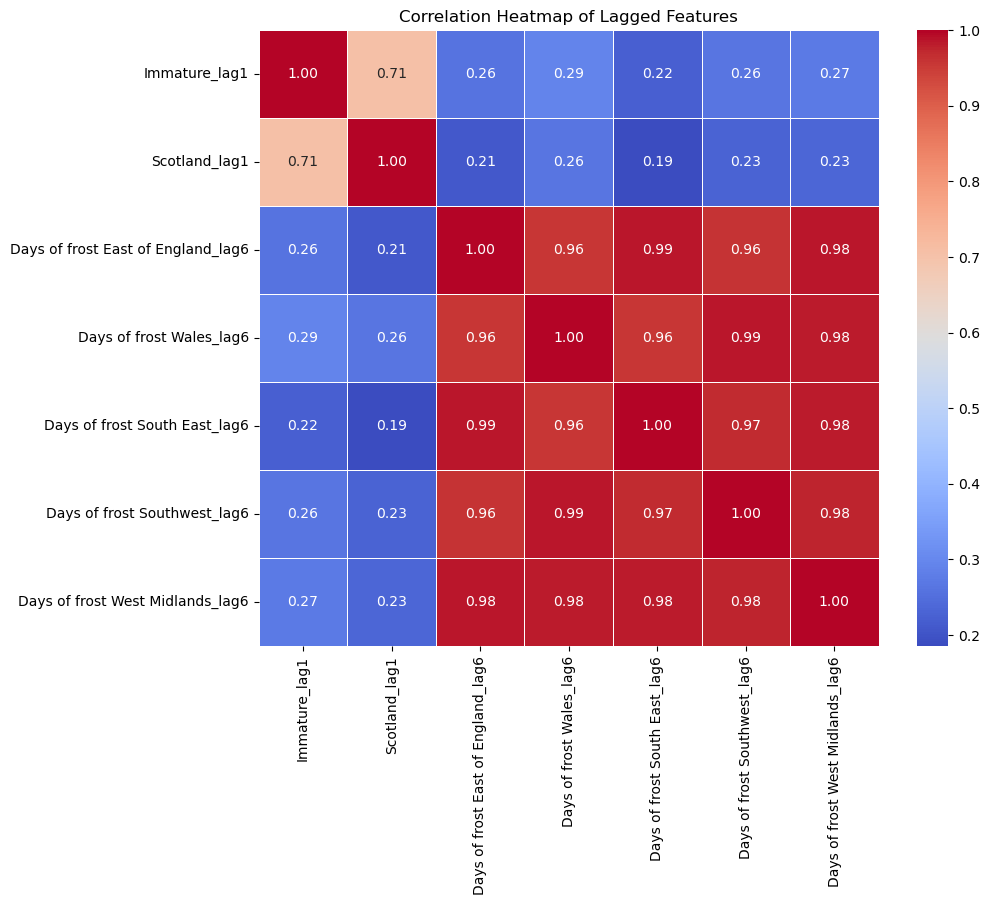

In [13]:
# Identify all lagged columns
lagged_columns = [col for col in df3.columns if "lag" in col]

# Create dataframe containing only lagged columns
df_lagged = df3[lagged_columns] 

# Compute correlation matrix for lagged features
lag_corr_matrix = df_lagged.corr()

# Plot heatmap for visual representation
plt.figure(figsize=(10, 8))
sns.heatmap(lag_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Lagged Features")
plt.show()

In [14]:
# Identify all columns with "lag" in the name
lagged_columns = [col for col in df3.columns if "lag" in col]

# Remove all lagged columns except 'Days of frost East of England_lag6'
columns_to_keep = ['Days of frost East of England_lag6']
df3 = df3.drop(columns=[col for col in lagged_columns if col not in columns_to_keep])

# Check the resulting dataframe
df3

,0-7 days,Immature,Adult,Scotland,East of England,South West,Wales,West Midlands,South East,Egg Peritonitis & Salpingitis,...,Hours of sunshine South East,Precipitation Scotland,Precipitation Southwest,Precipitation Wales,Precipitation West Midlands,Precipitation South East,Total death,Month_sin,Month_cos,Days of frost East of England_lag6
0,0,0,3,0,2,0,0,0,1,1,...,73.2,156.2,84.1,92.3,41.9,49.7,3,5.000000e-01,8.660254e-01,NaN
1,0,1,2,2,0,0,0,1,0,2,...,83.7,81.0,40.6,46.1,20.5,19.9,3,8.660254e-01,5.000000e-01,NaN
2,0,0,2,0,0,0,2,0,0,0,...,174.5,43.5,31.3,23.0,30.8,27.9,2,1.000000e+00,6.123234e-17,NaN
3,0,1,3,0,0,0,0,1,0,0,...,155.7,124.1,153.7,98.8,125.4,130.0,4,8.660254e-01,-5.000000e-01,NaN
4,0,2,0,0,0,0,0,2,0,0,...,191.6,78.1,51.2,59.5,44.9,41.6,2,5.000000e-01,-8.660254e-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0,0,2,0,2,0,0,0,0,1,...,209.2,176.3,53.4,87.3,23.7,32.8,2,-8.660254e-01,-5.000000e-01,2.3
152,0,1,1,1,0,0,0,0,0,1,...,129.8,91.1,168.7,146.2,122.1,141.3,2,-1.000000e+00,-1.836970e-16,1.4
153,0,0,2,0,0,0,2,0,0,0,...,88.0,117.1,124.5,104.5,61.1,79.7,2,-8.660254e-01,5.000000e-01,0.6
154,0,0,0,0,0,0,0,0,0,0,...,54.0,77.1,122.2,69.2,51.4,73.5,0,-5.000000e-01,8.660254e-01,0.0


In [15]:
# Fill NaN of lagged features with future trends

df3["Days of frost East of England_lag6"] = df3["Days of frost East of England_lag6"].fillna(method='bfill')

#### Apply PCA to Weather features only (since it's highly correlated with each other)

In [16]:
df3.shape

(156, 60)

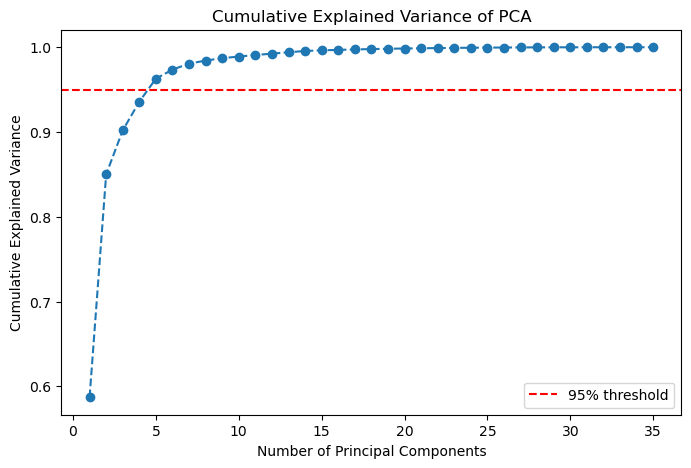

In [17]:
# Select columns based on specified keywords, excluding 'lag'
weather_keywords = ["Min", "Max", "Hours", "Days of frost", "Precipitation"]
weather_columns = [col for col in df3.columns if any(keyword in col for keyword in weather_keywords) and "lag" not in col]

# Extract the subset of relevant features
df_selected = df3[weather_columns]

# Handle missing values (imputation)
df_selected_clean = df_selected.copy()
df_selected_clean.fillna(df_selected_clean.mean(), inplace=True)  # Impute with column mean

# Standardize the selected features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected_clean)

# Apply PCA
pca = PCA()
pca.fit(df_scaled)

# Compute cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% threshold")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance of PCA")
plt.legend()
plt.show()

In [18]:
# Apply PCA with 5 components
pca = PCA(n_components=5)
df_pca = pca.fit_transform(df_scaled)

# Convert PCA results into a DataFrame with new column names
df_pca = pd.DataFrame(df_pca, columns=["PCA_Weather1", "PCA_Weather2", "PCA_Weather3", "PCA_Weather4", "PCA_Weather5"])

# Get explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Display explained variance for each PCA_Weather component
for i, variance in enumerate(explained_variance, 1):
    print(f"PCA_Weather{i}: {variance:.4f} ({variance * 100:.2f}%)")

PCA_Weather1: 0.5872 (58.72%)
PCA_Weather2: 0.2628 (26.28%)
PCA_Weather3: 0.0520 (5.20%)
PCA_Weather4: 0.0338 (3.38%)
PCA_Weather5: 0.0272 (2.72%)


In [19]:
# Apply PCA with 5 components
pca = PCA(n_components=5)
pca.fit(df_scaled)

# Compute PCA Loadings (Feature Contributions)
loadings_df = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), 
                           columns=["PCA_Weather1", "PCA_Weather2", "PCA_Weather3", "PCA_Weather4", "PCA_Weather5"], 
                           index=weather_columns)

# Extract Top 10 Features for All PCA Components
top_features_df = loadings_df.abs().apply(lambda x: x.nlargest(10).index.tolist(), axis=0)

# Convert to DataFrame for readability
top_features_df.index.name = "Principal Components"

print("\nTop 10 Features for Each PCA Component:")
print(top_features_df)


Top 10 Features for Each PCA Component:
                                  PCA_Weather1  \
Principal Components                             
0                       Max_temp West Midlands   
1                            Max_temp Scotland   
2                               Max_temp Wales   
3                           Max_temp Southwest   
4                          Max_temp South East   
5                     Max_temp East of England   
6                            Min_temp Scotland   
7                       Min_temp West Midlands   
8                     Min_temp East of England   
9                          Min_temp South East   

                                           PCA_Weather2  \
Principal Components                                      
0                       Hours of rainfall West Midlands   
1                                   Precipitation Wales   
2                           Precipitation West Midlands   
3                     Hours of rainfall East of England   
4   

#### Clustering based on final dataset

In [20]:
df4 = df3.copy()

In [21]:
weather_column_count_alt = sum(any(keyword in col for keyword in weather_keywords) and "lag" not in col for col in df3.columns)
print(f"Number of weather-related columns (excluding 'lag'): {weather_column_count_alt}")

Number of weather-related columns (excluding 'lag'): 35


In [22]:
df4.shape

(156, 60)

We currently have a dataset of 156 rows and 60 columns that still includes all Weather features: 

"Min/Max temperature

Days of frost

Hours of sunshine/rainfall

Precipitation"

Those features are highly correlated to each other, which we have applied PCA on those features to reduce from 35 to only 5 components.

=> We will replace all 35 with only 5 columns for the final Dataset before applying Clustering and Classification models.

In [23]:
# Select columns that do not contain weather-related metrics (except lagged ones)
filtered_columns = [col for col in df4.columns if not any(keyword in col for keyword in weather_keywords) or "lag" in col]

# Create a new DataFrame excluding those columns
df_filtered = df4[filtered_columns]

print(f"Number of columns retained: {df_filtered.shape[1]}")

# Merge filtered DataFrame with existing PCA components
df4 = pd.concat([df_filtered.reset_index(drop=True), df_pca], axis=1)

# Move "Total death" to the last column
df4 = df4[[col for col in df4.columns if col != "Total death"] + ["Total death"]]

df4.columns

Number of columns retained: 25


Index(['0-7 days', 'Immature', 'Adult', 'Scotland', 'East of England',
       'South West', 'Wales', 'West Midlands', 'South East',
       'Egg Peritonitis & Salpingitis', 'Colisepticaemia',
       'Yolk sac infection/ omphalitis', 'Broiler ascites', 'Red Mite',
       'Neoplasm', 'Marek's Disease', 'Slaughter (Million birds)',
       'Production (Thousand tonnes)', 'Eggs Import (Million Dozen)',
       'Eggs Export (Million Dozen)', 'Eggs RPI average price (per dozen)',
       'Month_sin', 'Month_cos', 'Days of frost East of England_lag6',
       'PCA_Weather1', 'PCA_Weather2', 'PCA_Weather3', 'PCA_Weather4',
       'PCA_Weather5', 'Total death'],
      dtype='object')

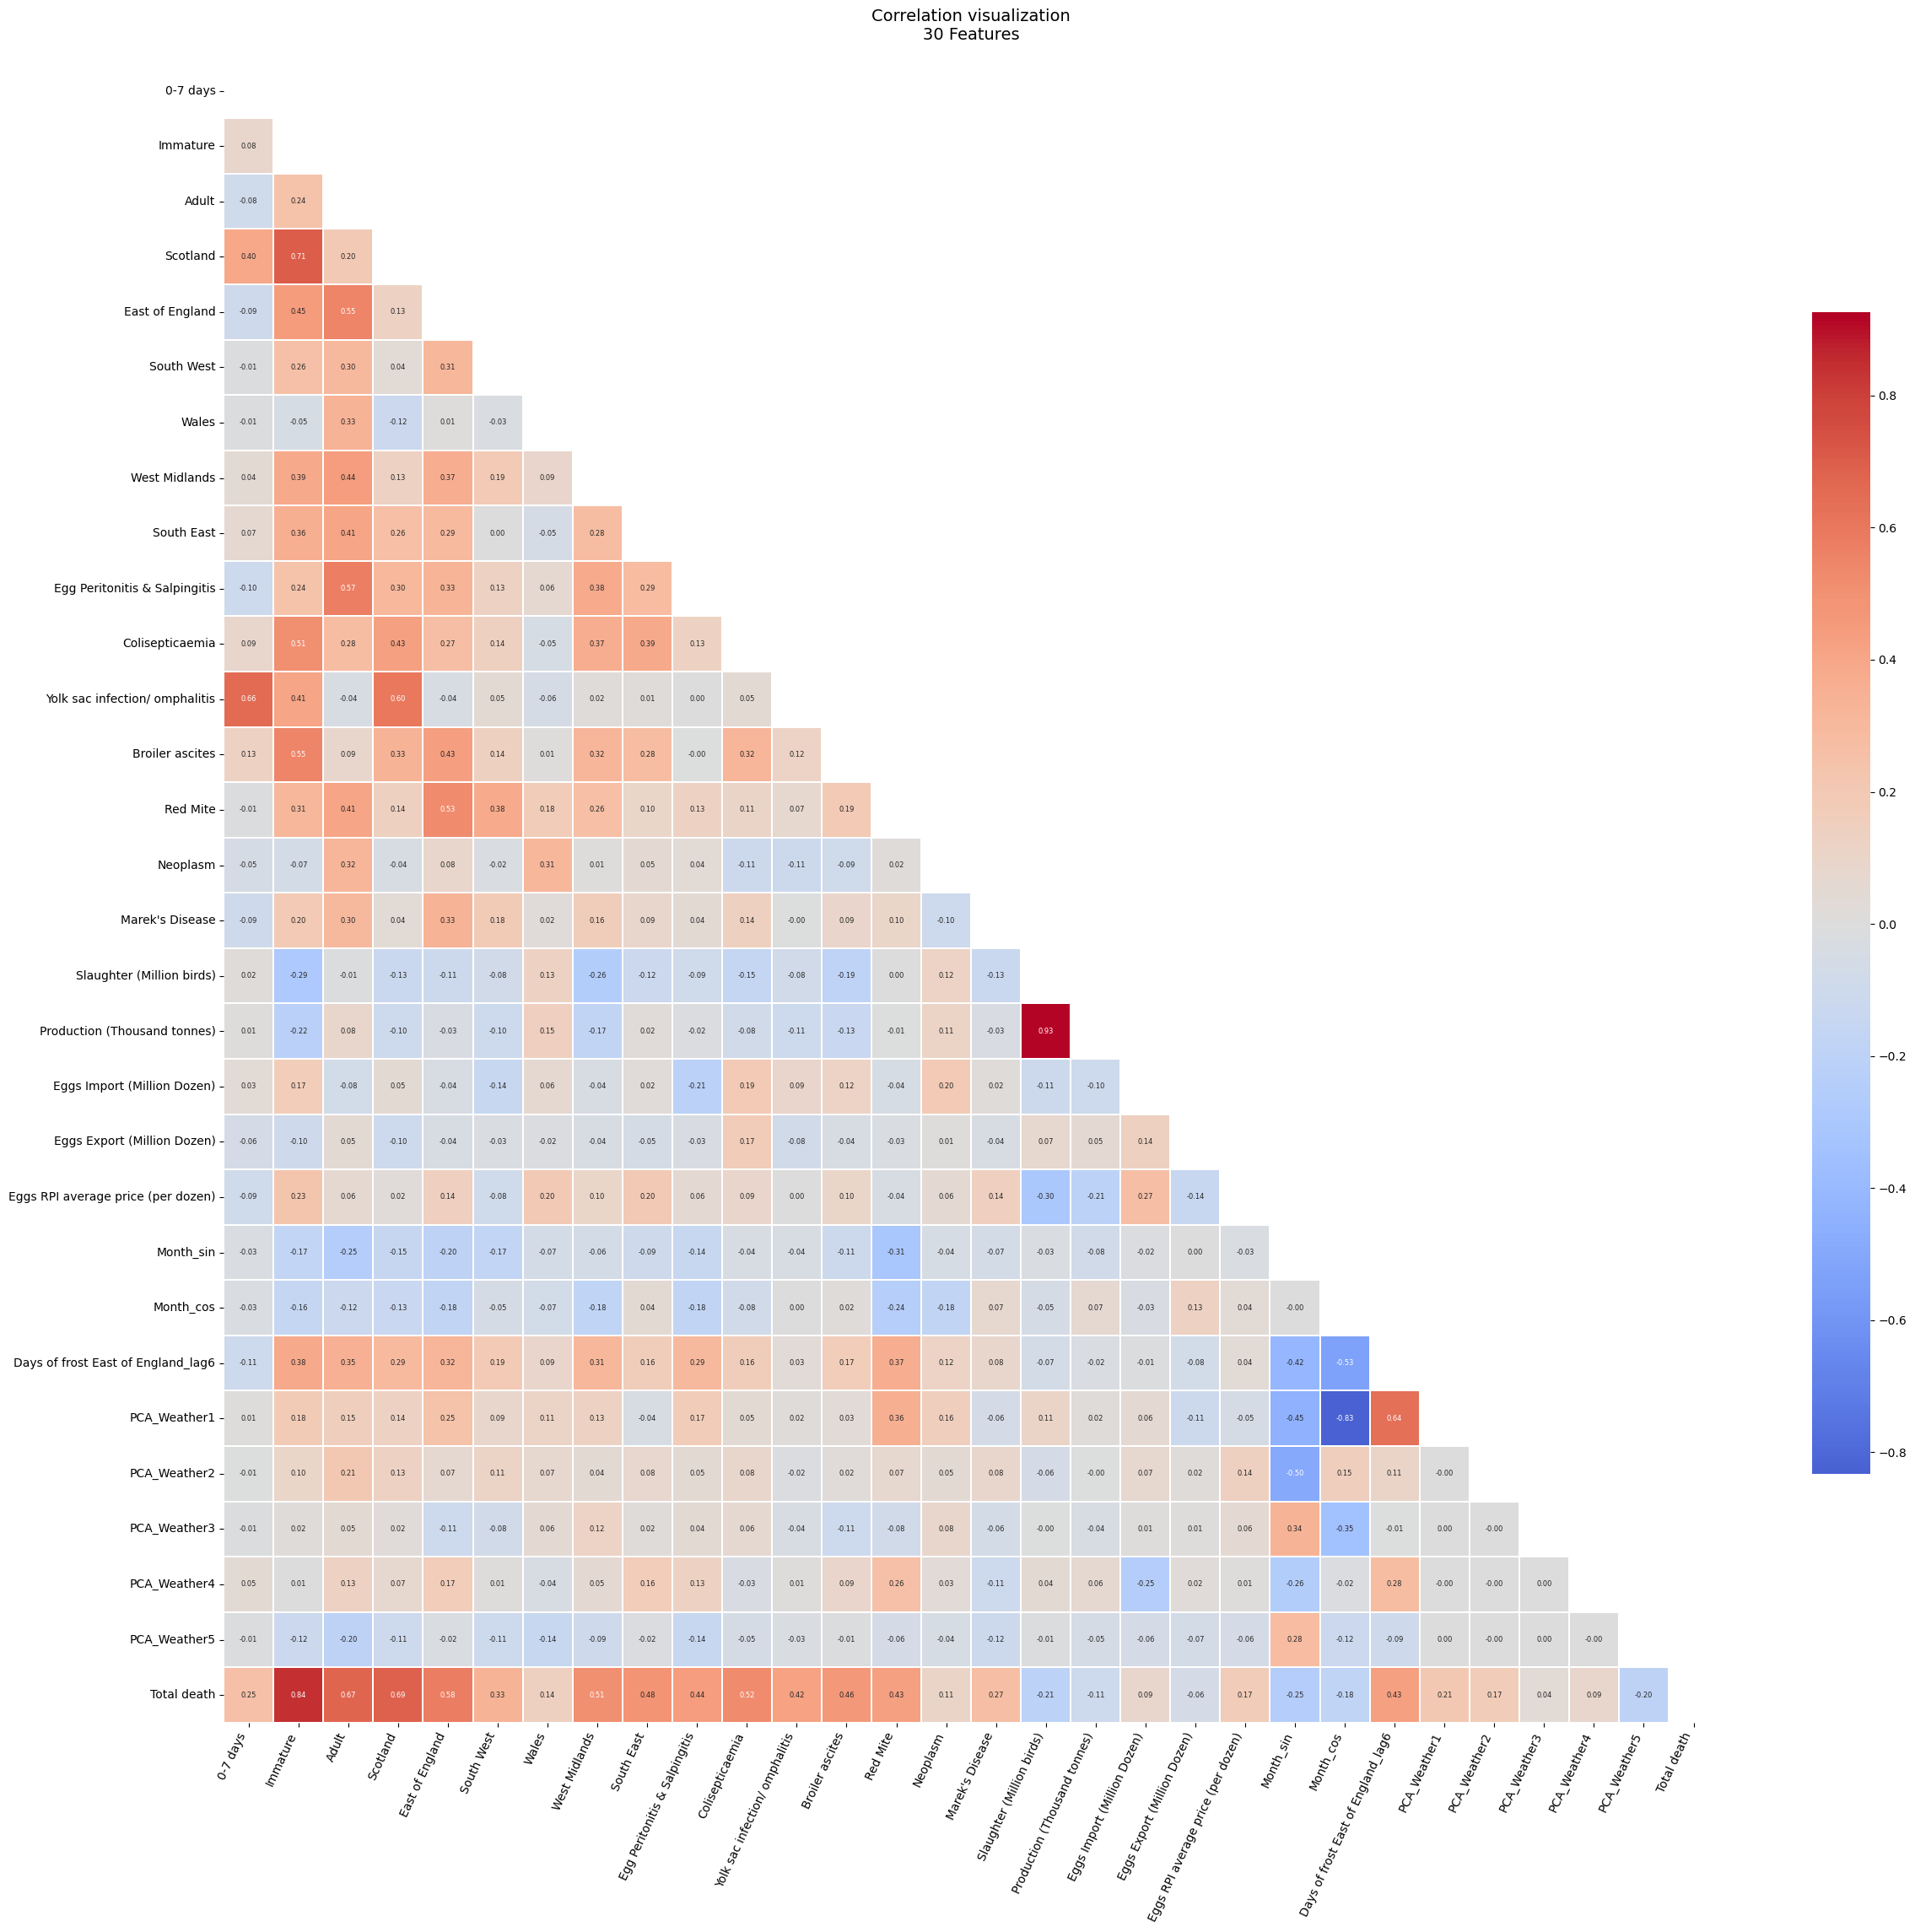

In [24]:
def correlation_visual(df, exclude_cols=0, correlation_threshold=0.7, figsize=(25, 23)):
   
    numeric_cols = df.select_dtypes(include=['number']).columns
    analyzed_cols = numeric_cols[exclude_cols:]
    corr_matrix = df[analyzed_cols].corr()
    
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
    
    # Create heatmap 
    ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', mask=mask,
                    annot_kws={'size': 6}, linewidths=0.1, cbar_kws={'shrink': 0.7})
    
    plt.xticks(rotation=65, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(f'Correlation visualization\n{len(analyzed_cols)} Features', 
              pad=20, fontsize=14)
    plt.tight_layout()
    plt.show()

correlation_results = correlation_visual(df4)

##### Final filtering

In [25]:
df5 = df4.copy()

In [26]:
# Check and remove all features that correlated more than 0.5 with each other, then compare and remove the one with lower correlation with "Total death"

In [27]:
def remove_highly_correlated_features(df, response_var, threshold=0.5):
    # Select explanatory features (from column 3 to -1)
    X = df.iloc[:, :-1]
    y = df[response_var]

    # Compute correlation matrix
    corr_matrix = X.corr().abs()

    # Sort features by correlation with response variable
    response_corr = X.corrwith(y).abs().sort_values(ascending=False)

    # Track removed features
    removed_features = set()
    
    for feature in response_corr.index:
        if feature in removed_features:
            continue
        
        # Find highly correlated features
        correlated_features = corr_matrix.loc[feature, corr_matrix.loc[feature] >= threshold].index.tolist()
        
        # Remove all correlated features except the strongest one
        for correlated_feature in correlated_features:
            if correlated_feature != feature:  # Don't remove the main feature
                if response_corr[correlated_feature] < response_corr[feature]:  
                    removed_features.add(correlated_feature)

    # Keep only uncorrelated features
    remaining_features = [feature for feature in X.columns if feature not in removed_features]
    df_filtered = df[remaining_features + [response_var]]

    print(f"Removed features: {removed_features}")
    print(f"Remaining features: {len(remaining_features)}")

    return df_filtered

df_filtered = remove_highly_correlated_features(df5, "Total death")

Removed features: {'Colisepticaemia', 'Month_cos', 'Production (Thousand tonnes)', '0-7 days', 'East of England', 'PCA_Weather1', 'Scotland', 'Egg Peritonitis & Salpingitis', 'Broiler ascites'}
Remaining features: 20


In [28]:
df6 = df_filtered

In [29]:
filtered_df = df6.copy()

In [30]:
filtered_df

,Immature,Adult,South West,Wales,West Midlands,South East,Yolk sac infection/ omphalitis,Red Mite,Neoplasm,Marek's Disease,...,Eggs Import (Million Dozen),Eggs Export (Million Dozen),Eggs RPI average price (per dozen),Month_sin,Days of frost East of England_lag6,PCA_Weather2,PCA_Weather3,PCA_Weather4,PCA_Weather5,Total death
0,0,3,0,0,0,1,0,0,0,1,...,10.3,0.7,309,5.000000e-01,9.2,-1.825240,-1.363307,0.590886,0.306910,3
1,1,2,0,0,1,0,0,0,0,0,...,9.8,0.7,311,8.660254e-01,9.2,-5.759073,-1.072032,1.506746,-0.866313,3
2,0,2,0,2,0,0,0,0,1,0,...,12.9,0.8,311,1.000000e+00,9.2,-4.345198,0.206567,-1.935279,-0.527678,2
3,1,3,0,0,1,0,0,0,0,0,...,14.0,0.7,312,8.660254e-01,9.2,2.129038,3.831355,-0.624267,0.047142,4
4,2,0,0,0,2,0,0,0,0,0,...,15.2,0.8,312,5.000000e-01,9.2,-1.951656,1.029047,-1.264003,0.455468,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0,2,0,0,0,0,0,0,0,0,...,13.1,2.6,323,-8.660254e-01,2.3,0.191715,-2.419336,1.279577,1.186250,2
152,1,1,0,0,0,0,0,0,0,0,...,12.5,3.3,326,-1.000000e+00,1.4,4.835327,2.476487,0.099617,-1.862836,2
153,0,2,0,2,0,0,0,0,1,0,...,14.3,3.5,326,-8.660254e-01,0.6,1.674814,-0.731307,-0.753358,-1.170390,2
154,0,0,0,0,0,0,0,0,0,0,...,13.7,2.2,328,-5.000000e-01,0.0,-0.582046,-0.387324,-0.263992,-2.058433,0


#### Clustering

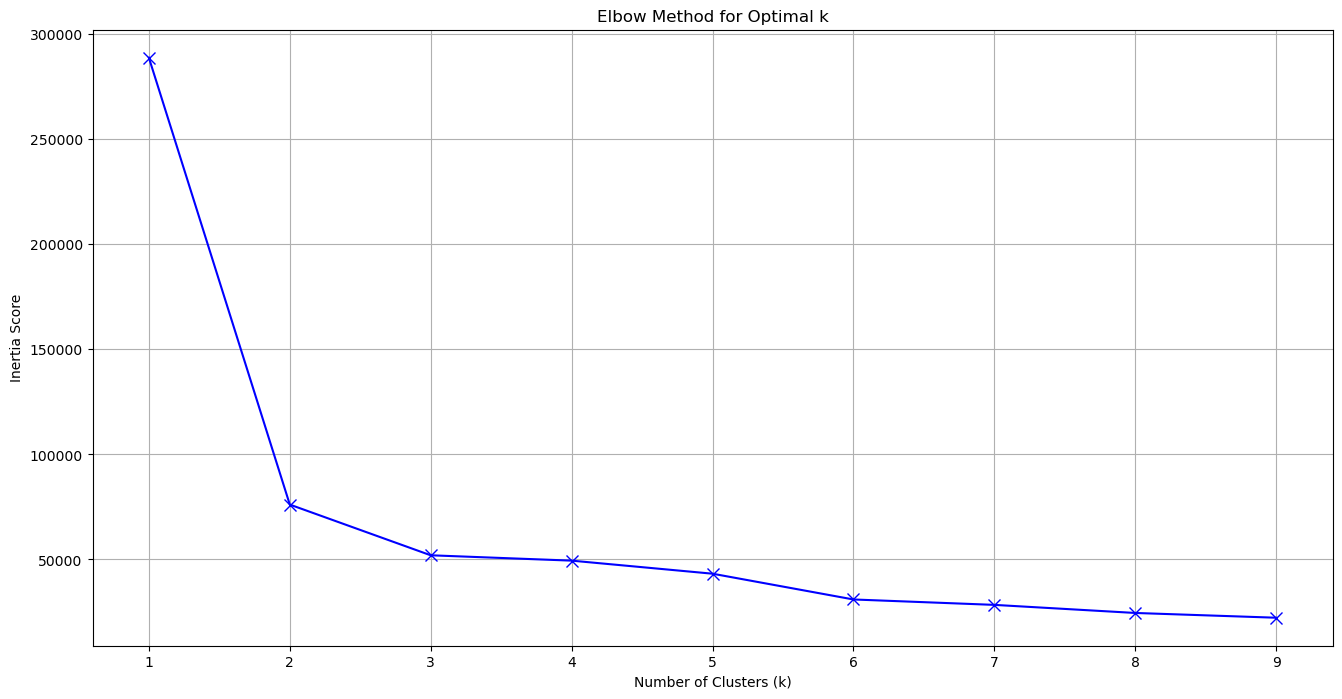

In [31]:
filtered_df_kmeans = filtered_df.iloc[:, :-1]

# Perform the Elbow Method
inertia_scores = []
kmeans_params = range(1, 10)

for k in kmeans_params:
    model = KMeans(n_clusters=k, random_state=0) 
    model.fit(filtered_df_kmeans)  
    inertia_scores.append(model.inertia_)

# Plot Elbow Method analysis
plt.figure(figsize=(16, 8))
plt.plot(kmeans_params, inertia_scores, "bx-", markersize=8)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia Score")
plt.title("Elbow Method for Optimal k")
plt.grid(True) 
plt.show()

In [32]:
# Choose the optimal k 
optimal_k = 2

# Train K-Means with the optimal number of clusters
model = KMeans(n_clusters=optimal_k, random_state=0)
model.fit(filtered_df_kmeans)

# Assign cluster labels to the dataset
filtered_df_kmeans["Cluster"] = model.predict(filtered_df_kmeans)

# Check how many samples are in each cluster
print(filtered_df_kmeans["Cluster"].value_counts())

Cluster
0    80
1    76
Name: count, dtype: int64


In [33]:
# Extract centroids from the trained model
centroids = model.cluster_centers_

# Ensure correct feature count by excluding 'Cluster' column
columns = filtered_df_kmeans.drop(columns=["Cluster"], errors="ignore").columns

# Convert centroids into a DataFrame with corrected feature names
centroids_df = pd.DataFrame(centroids, columns=columns)
centroids_df["Cluster"] = range(optimal_k)

print("\nCentroids for Each Cluster:")
centroids_df


Centroids for Each Cluster:


,Immature,Adult,South West,Wales,West Midlands,South East,Yolk sac infection/ omphalitis,Red Mite,Neoplasm,Marek's Disease,...,Eggs Import (Million Dozen),Eggs Export (Million Dozen),Eggs RPI average price (per dozen),Month_sin,Days of frost East of England_lag6,PCA_Weather2,PCA_Weather3,PCA_Weather4,PCA_Weather5,Cluster
0,0.537500,1.287500,0.225000,0.062500,0.112500,0.037500,0.212500,0.162500,0.100000,0.062500,...,12.541250,2.830000,235.925000,0.012500,3.237500,-0.389583,-0.078211,-0.008909,-0.001109,0
1,1.342105,1.526316,0.157895,0.289474,0.276316,0.223684,0.131579,0.105263,0.144737,0.171053,...,13.471053,1.565789,309.157895,-0.013158,3.557895,0.410088,0.082328,0.009378,0.001168,1


### Determine the threshold for Total death (using KBin Discretize and Mean/std)

In [34]:
def threshold_determination(df, column_name, n_bins=3):

    strategies = ["kmeans", "uniform", "quantile"]
    bin_labels = {0: "Low", 1: "Medium", 2: "High"}
    
    bin_counts_summary = {}

    # Apply KBinsDiscretizer-based methods
    for strategy in strategies:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        df[f"Death Category ({strategy})"] = discretizer.fit_transform(df[[column_name]]).astype(int)
        
        df[f"Death Category ({strategy})"] = df[f"Death Category ({strategy})"].map(bin_labels)
        
        bin_counts_summary[strategy] = df[f"Death Category ({strategy})"].value_counts()

    # **Apply Mean/Std-Based Binning**
    mean_death = df[column_name].mean()
    std_death = df[column_name].std()
    low_thresh = mean_death - std_death
    high_thresh = mean_death + std_death

    def categorize_death(val):
        if val == 0:
            return 'Low'
        elif val > high_thresh:
            return 'High'
        else:
            return 'Medium'

    df["Death Category (mean/std)"] = df[column_name].apply(categorize_death)

    # Store bin counts for mean/std method
    bin_counts_summary["mean/std"] = df["Death Category (mean/std)"].value_counts()
    df_bin_counts = pd.DataFrame(bin_counts_summary).fillna(0).astype(int)  # Fill NaN and convert to int
    
    return df_bin_counts

df_bin_counts = threshold_determination(filtered_df, "Total death", n_bins=3)
print("\nComparison of Binning Strategies:\n")
display(df_bin_counts)


Comparison of Binning Strategies:



,kmeans,uniform,quantile,mean/std
High,7,3,57,20
Low,117,136,42,42
Medium,32,17,57,94


=> Since we have a huge gap between each category (except for quantile), we will first build the models and then apply balancing later to compare.

In [95]:
filtered_df.columns

Index(['Immature', 'Adult', 'South West', 'Wales', 'West Midlands',
       'South East', 'Yolk sac infection/ omphalitis', 'Red Mite', 'Neoplasm',
       'Marek's Disease', 'Slaughter (Million birds)',
       'Eggs Import (Million Dozen)', 'Eggs Export (Million Dozen)',
       'Eggs RPI average price (per dozen)', 'Month_sin',
       'Days of frost East of England_lag6', 'PCA_Weather2', 'PCA_Weather3',
       'PCA_Weather4', 'PCA_Weather5', 'Total death',
       'Death Category (kmeans)', 'Death Category (uniform)',
       'Death Category (quantile)', 'Death Category (mean/std)'],
      dtype='object')

## Classification models

### Using train_test_split

#### Testing the number of k values for KNN before applying Classifications

In [36]:
filtered_df2 = filtered_df.copy()

In [37]:
filtered_df2

,Immature,Adult,South West,Wales,West Midlands,South East,Yolk sac infection/ omphalitis,Red Mite,Neoplasm,Marek's Disease,...,Days of frost East of England_lag6,PCA_Weather2,PCA_Weather3,PCA_Weather4,PCA_Weather5,Total death,Death Category (kmeans),Death Category (uniform),Death Category (quantile),Death Category (mean/std)
0,0,3,0,0,0,1,0,0,0,1,...,9.2,-1.825240,-1.363307,0.590886,0.306910,3,Low,Low,High,Medium
1,1,2,0,0,1,0,0,0,0,0,...,9.2,-5.759073,-1.072032,1.506746,-0.866313,3,Low,Low,High,Medium
2,0,2,0,2,0,0,0,0,1,0,...,9.2,-4.345198,0.206567,-1.935279,-0.527678,2,Low,Low,Medium,Medium
3,1,3,0,0,1,0,0,0,0,0,...,9.2,2.129038,3.831355,-0.624267,0.047142,4,Medium,Low,High,Medium
4,2,0,0,0,2,0,0,0,0,0,...,9.2,-1.951656,1.029047,-1.264003,0.455468,2,Low,Low,Medium,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0,2,0,0,0,0,0,0,0,0,...,2.3,0.191715,-2.419336,1.279577,1.186250,2,Low,Low,Medium,Medium
152,1,1,0,0,0,0,0,0,0,0,...,1.4,4.835327,2.476487,0.099617,-1.862836,2,Low,Low,Medium,Medium
153,0,2,0,2,0,0,0,0,1,0,...,0.6,1.674814,-0.731307,-0.753358,-1.170390,2,Low,Low,Medium,Medium
154,0,0,0,0,0,0,0,0,0,0,...,0.0,-0.582046,-0.387324,-0.263992,-2.058433,0,Low,Low,Low,Low


##### Encode all labels to match {"Low": 0, "Medium": 1, "High": 2}

In [38]:
# Define label mapping
label_mapping = {"Low": 0, "Medium": 1, "High": 2}

# Standardize all categorical columns and apply mapping
for col in filtered_df2.select_dtypes(include=["object"]).columns:  # Only process text columns
    filtered_df2[col] = filtered_df2[col].str.strip().str.title().map(label_mapping)

##### Define optimal k-neighbors

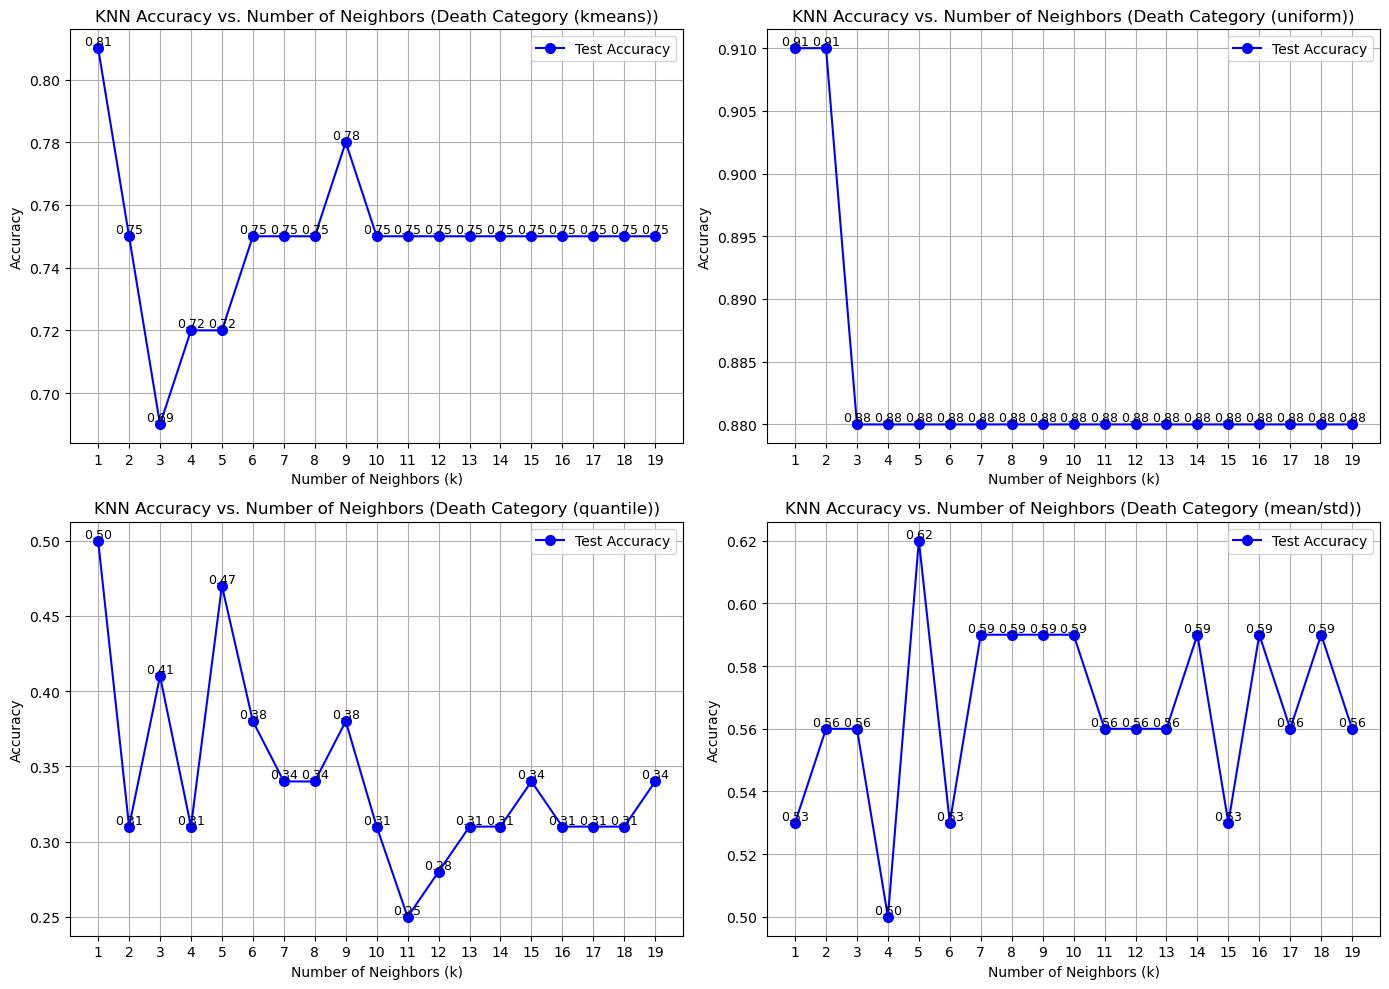

In [39]:
def determine_optimal_neighbors(df, y_columns, k_range=list(range(1, 20))):    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, y_var in enumerate(y_columns):
        # Ensure no mapping is applied (assumes values are already numerical)
        X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-5], df[y_var], test_size=0.2, stratify=df[y_var], random_state=0)

        accuracy_scores = []
        
        for k in k_range:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            
            acc = round(accuracy_score(y_test, y_pred), 2)
            accuracy_scores.append((k, acc))

        # Extract sorted k-values and accuracy scores
        k_values_sorted = [score[0] for score in sorted(accuracy_scores, key=lambda x: x[0])]
        accuracies_sorted = [score[1] for score in sorted(accuracy_scores, key=lambda x: x[0])]

        # Plot
        ax = axes[idx]
        ax.plot(k_values_sorted, accuracies_sorted, marker='o', markersize=7, linestyle='-', color='b', label="Test Accuracy")

        # Label accuracy values on the plot
        for k, acc in zip(k_values_sorted, accuracies_sorted):
            ax.text(k, acc, f"{acc:.2f}", fontsize=9, ha="center", va="bottom", color="black")

        ax.set_xlabel("Number of Neighbors (k)")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"KNN Accuracy vs. Number of Neighbors ({y_var})")
        ax.set_xticks(k_values_sorted)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Run with death categories
death_categories = ["Death Category (kmeans)", "Death Category (uniform)", "Death Category (quantile)", "Death Category (mean/std)"]
best_k_dict = determine_optimal_neighbors(filtered_df2, death_categories)

##### Calculate metrics and compare to choose k-neigbor

In [40]:
def compute_knn_metrics(df, y_var, k_list):
    # Ensure the target variable remains unchanged (no explicit mapping)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-5], df[y_var], test_size=0.2, stratify=df[y_var], random_state=0)

    results = []
    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Compute evaluation metrics
        acc = round(accuracy_score(y_test, y_pred), 2)
        prec = round(precision_score(y_test, y_pred, average='macro', zero_division=0), 2)
        rec = round(recall_score(y_test, y_pred, average='macro', zero_division=0), 2)
        f1 = round(f1_score(y_test, y_pred, average='macro', zero_division=0), 2)
        auc_roc = round(roc_auc_score(y_test, knn.predict_proba(X_test), multi_class="ovr"), 2) if hasattr(knn, "predict_proba") else None

        results.append([k, acc, prec, rec, f1, auc_roc])

    # Convert results into a DataFrame
    results_df = pd.DataFrame(results, columns=["K", "Accuracy", "Precision", "Recall", "F1-score", "AUC-ROC"])

    return results_df

In [41]:
# Calculate for Death Category (uniform)
k_values_uniform = list(range(3, 20))
uniform_category = "Death Category (uniform)"

uniform_metrics = compute_knn_metrics(filtered_df2, uniform_category, k_values_uniform)
print("\nMetrics for Uniform:")
display(uniform_metrics)


Metrics for Uniform:


,K,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,3,0.88,0.29,0.33,0.31,0.88
1,4,0.88,0.29,0.33,0.31,0.86
2,5,0.88,0.29,0.33,0.31,0.84
3,6,0.88,0.29,0.33,0.31,0.83
4,7,0.88,0.29,0.33,0.31,0.82
5,8,0.88,0.29,0.33,0.31,0.80
6,9,0.88,0.29,0.33,0.31,0.77
7,10,0.88,0.29,0.33,0.31,0.78
8,11,0.88,0.29,0.33,0.31,0.81
9,12,0.88,0.29,0.33,0.31,0.81


In [42]:
# Summarize the findings:
# Define the final results
data = {
    "Death Category": ["Kmeans", "Uniform", "Quantile", "Mean/Std"],
    "K": [9, 3, 5, 5],
}

neighbor_results = pd.DataFrame(data)
print(neighbor_results)

  Death Category  K
0         Kmeans  9
1        Uniform  3
2       Quantile  5
3       Mean/Std  5


#### Perform Classification Model

In [43]:
def evaluate_classifiers(df, y_var, n_neighbors=7):
    # Split dataset without Label Encoding
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-5], df[y_var], test_size=0.2, stratify=df[y_var], random_state=0)

    # Define classifiers
    classifiers = [
        ("SVM", SVC(kernel="linear", probability=True)),
        ("GaussianNB", GaussianNB()),
        ("Random Forest", RandomForestClassifier()),
        ("KNN", KNeighborsClassifier(n_neighbors=n_neighbors)), 
        ("Gradient Boosting", GradientBoostingClassifier())
    ]

    results = []  

    # Train and evaluate classifiers
    for name, clf in classifiers:
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)

        # Compute metrics
        acc = round(accuracy_score(y_test, y_hat), 2)
        prec = round(precision_score(y_test, y_hat, average='macro', zero_division=0), 2)
        rec = round(recall_score(y_test, y_hat, average='macro', zero_division=0), 2)
        f1 = round(f1_score(y_test, y_hat, average='macro', zero_division=0), 2)

        results.append([name, acc, prec, rec, f1])

    df_results = pd.DataFrame(results, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"])
    df_results.set_index("Classifier", inplace=True)

    # Plot results
    fig, ax = plt.subplots(figsize=(12, 6))
    df_results[["Accuracy", "Precision", "Recall", "F1-score"]].plot(kind="bar", ax=ax, rot=30, grid=True)

    ax.legend(title="Performance Metrics", fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc="upper left")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, label_type="edge")

    ax.set_title(f"Classifier Performance Comparison ({y_var})", fontsize=14)
    ax.set_xlabel("Classifier", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.show()

    return df_results

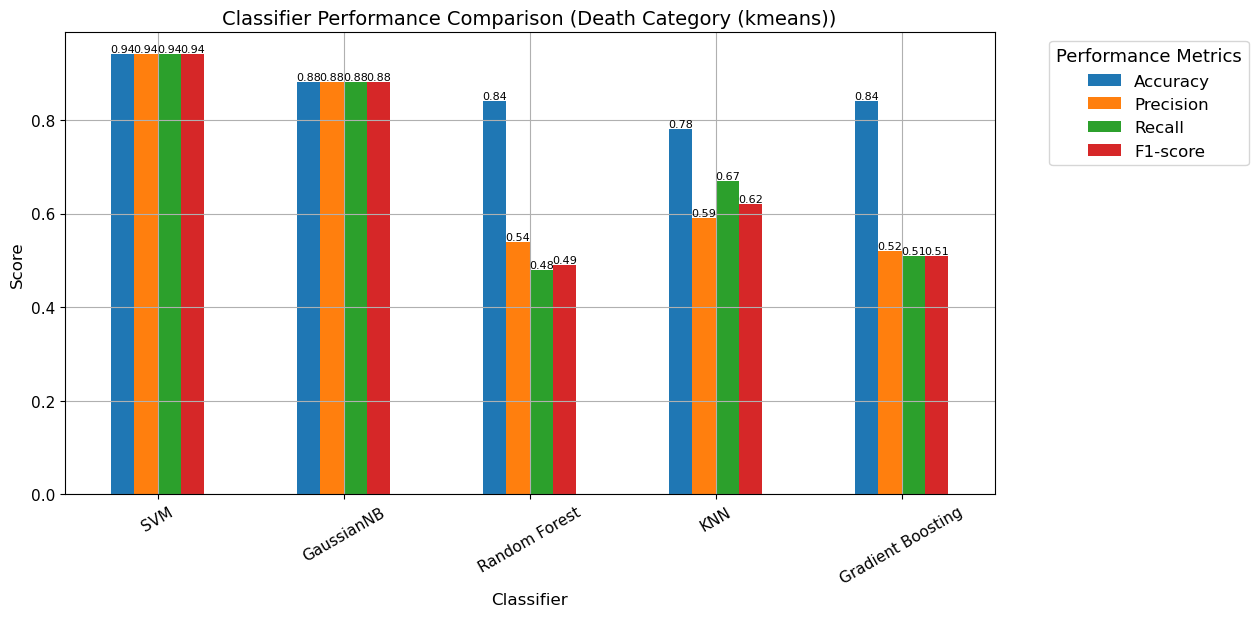

In [44]:
Kmeans_results = evaluate_classifiers(filtered_df2, "Death Category (kmeans)", n_neighbors=9)

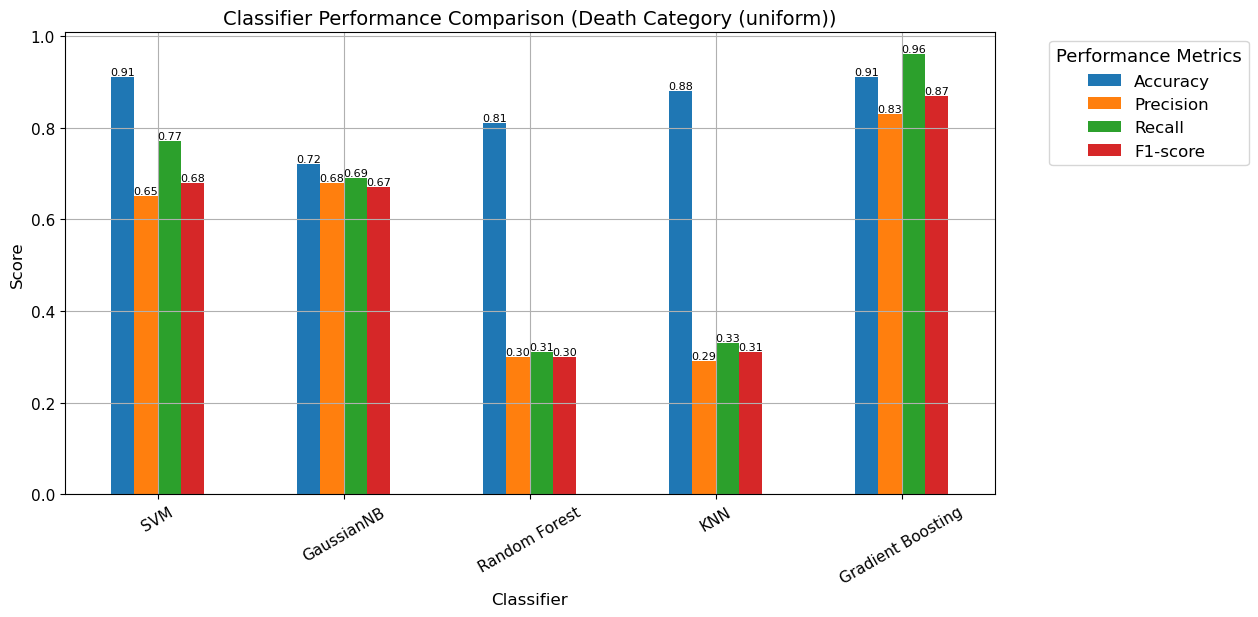

In [45]:
Uniform_results = evaluate_classifiers(filtered_df2, "Death Category (uniform)", n_neighbors=3)

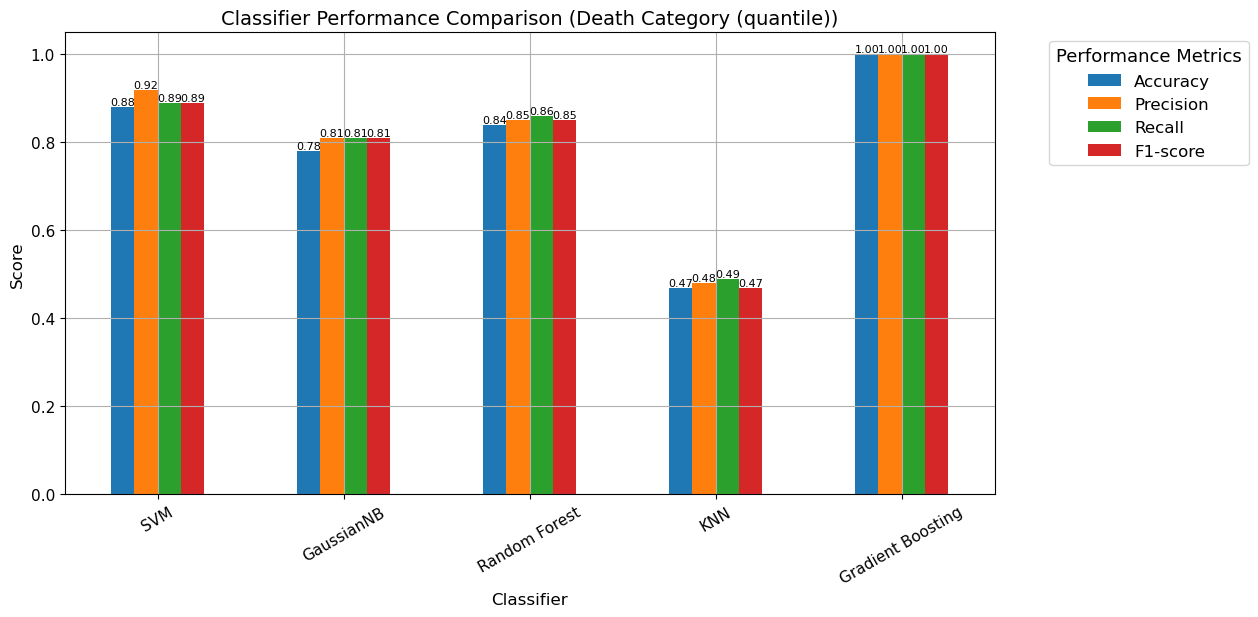

In [46]:
Quantile_results = evaluate_classifiers(filtered_df2, "Death Category (quantile)", n_neighbors=5)

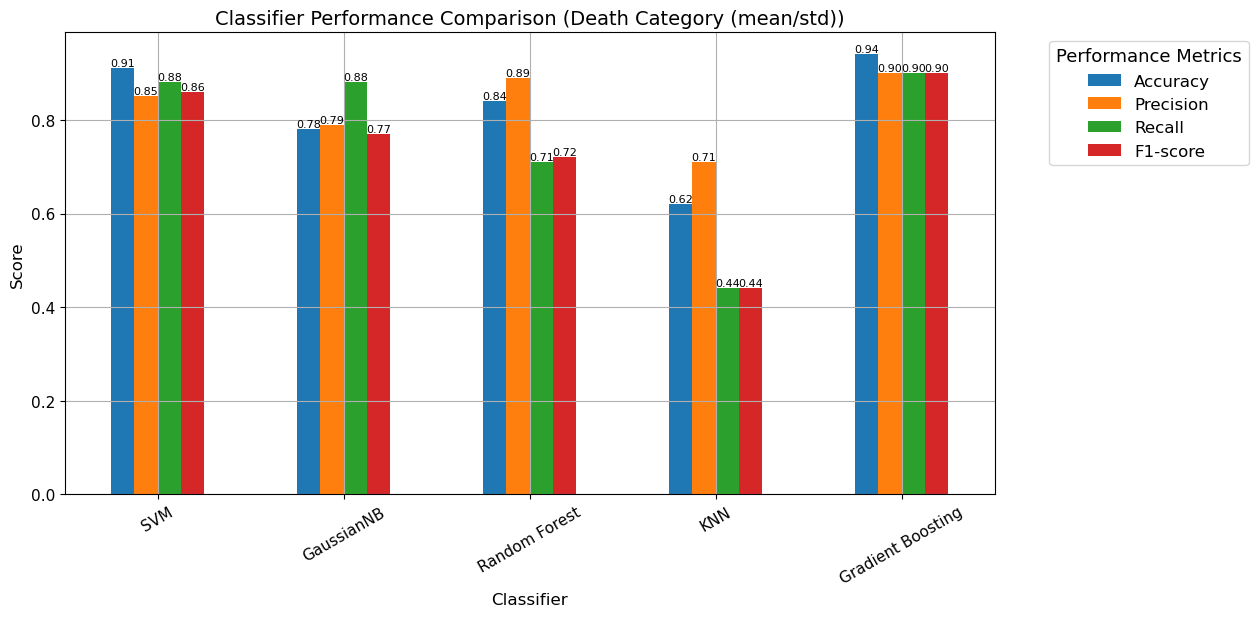

In [47]:
MeanStd_results = evaluate_classifiers(filtered_df2, "Death Category (mean/std)", n_neighbors=5)

#### Hyperparameters Tuning

In [48]:
def tune_classifiers(df, y_var):
    # Split dataset without Label Encoding
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-5], df[y_var], test_size=0.2, stratify=df[y_var], random_state=0)

    classifiers = {
        "SVM": (SVC(probability=True), {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10, 100]}),
        "Random Forest": (RandomForestClassifier(), 
                          {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 
                           'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10]}),
        "Gradient Boosting": (GradientBoostingClassifier(),
                              {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1], 
                               'max_depth': [2, 4], 'min_samples_split': [5, 10],
                               'subsample': [0.6, 0.8, 1.0],
                               'max_features': ['sqrt', 0.5]})
    }

    best_models = {}
    best_params = {}

    # Hyperparameter tuning for each classifier
    for name, (clf, param_grid) in classifiers.items():
        grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        best_params[name] = grid_search.best_params_

    # Evaluate tuned classifiers on the test set
    results = []
    for name, tuned_clf in best_models.items():
        y_pred = tuned_clf.predict(X_test)
        acc = round(accuracy_score(y_test, y_pred), 2)
        prec = round(precision_score(y_test, y_pred, average='macro', zero_division=0), 2)
        rec = round(recall_score(y_test, y_pred, average='macro', zero_division=0), 2)
        f1 = round(f1_score(y_test, y_pred, average='macro', zero_division=0), 2)

        results.append([name, acc, prec, rec, f1])

    # Store results in a DataFrame
    df_results = pd.DataFrame(results, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"])
    df_results.set_index("Classifier", inplace=True)

    return df_results, best_params

In [49]:
tune_classifiers(filtered_df2, "Death Category (kmeans)")

(                   Accuracy  Precision  Recall  F1-score
 Classifier                                              
 SVM                    0.94       0.94    0.94      0.94
 Random Forest          0.81       0.48    0.46      0.47
 Gradient Boosting      0.84       0.52    0.51      0.51,
 {'SVM': {'C': 1, 'kernel': 'linear'},
  'Random Forest': {'max_depth': 10,
   'min_samples_leaf': 1,
   'min_samples_split': 5,
   'n_estimators': 100},
  'Gradient Boosting': {'learning_rate': 0.1,
   'max_depth': 2,
   'max_features': 0.5,
   'min_samples_split': 5,
   'n_estimators': 50,
   'subsample': 0.8}})

In [50]:
tune_classifiers(filtered_df2, "Death Category (uniform)")

(                   Accuracy  Precision  Recall  F1-score
 Classifier                                              
 SVM                    0.91       0.65    0.77      0.68
 Random Forest          0.84       0.30    0.32      0.31
 Gradient Boosting      0.91       0.83    0.96      0.87,
 {'SVM': {'C': 1, 'kernel': 'linear'},
  'Random Forest': {'max_depth': 10,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 50},
  'Gradient Boosting': {'learning_rate': 0.5,
   'max_depth': 4,
   'max_features': 0.5,
   'min_samples_split': 5,
   'n_estimators': 50,
   'subsample': 1.0}})

In [51]:
tune_classifiers(filtered_df2, "Death Category (quantile)")

(                   Accuracy  Precision  Recall  F1-score
 Classifier                                              
 SVM                    0.88       0.92    0.89      0.89
 Random Forest          0.84       0.87    0.86      0.85
 Gradient Boosting      0.97       0.97    0.97      0.97,
 {'SVM': {'C': 1, 'kernel': 'linear'},
  'Random Forest': {'max_depth': 10,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 50},
  'Gradient Boosting': {'learning_rate': 0.1,
   'max_depth': 4,
   'max_features': 0.5,
   'min_samples_split': 10,
   'n_estimators': 50,
   'subsample': 1.0}})

In [52]:
tune_classifiers(filtered_df2, "Death Category (mean/std)")

(                   Accuracy  Precision  Recall  F1-score
 Classifier                                              
 SVM                    0.91       0.85    0.88      0.86
 Random Forest          0.88       0.92    0.73      0.75
 Gradient Boosting      0.84       0.75    0.71      0.72,
 {'SVM': {'C': 1, 'kernel': 'linear'},
  'Random Forest': {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 10,
   'n_estimators': 200},
  'Gradient Boosting': {'learning_rate': 0.1,
   'max_depth': 2,
   'max_features': 'sqrt',
   'min_samples_split': 5,
   'n_estimators': 50,
   'subsample': 0.8}})

### K-fold Cross-Validation

In [53]:
filtered_df3 = filtered_df2.copy()

#### Determine optimal neighbors for each Death Category (KNN)

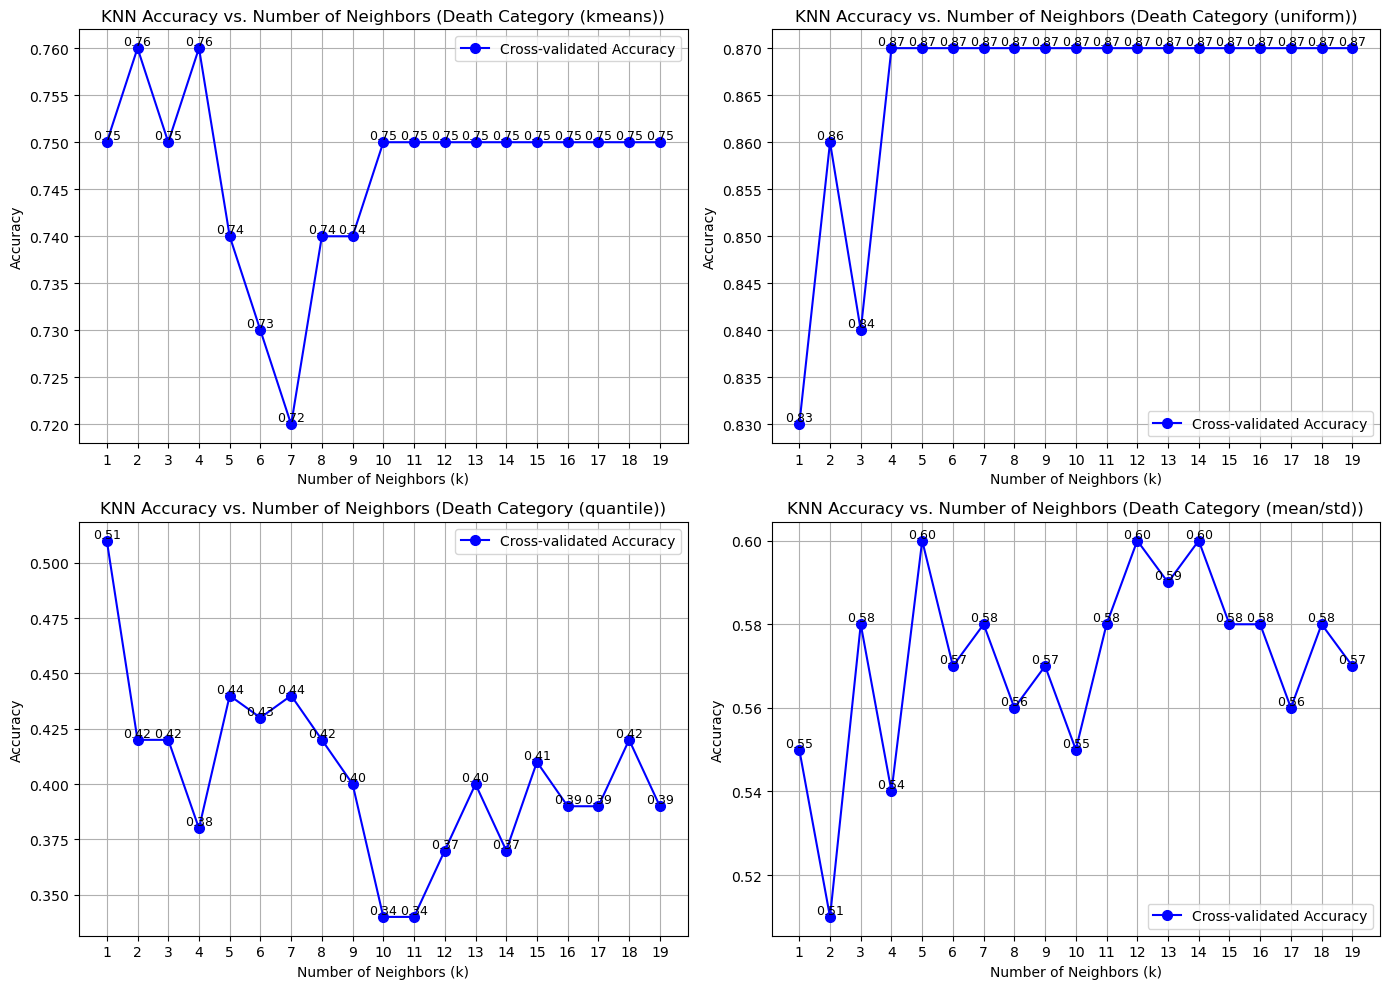

In [54]:
def determine_optimal_neighbors_kfold(filtered_df3, y_columns, k_range=list(range(1, 20))):    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, y_var in enumerate(y_columns):
        # Ensure the target variable remains unchanged (no Label Encoding)
        X = filtered_df3.iloc[:, :-5]
        y = filtered_df3[y_var]

        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
        accuracy_scores = []

        for k in k_range:
            acc_scores = []

            for train_idx, test_idx in skf.split(X, y):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                knn = KNeighborsClassifier(n_neighbors=k)
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_test)

                acc_scores.append(accuracy_score(y_test, y_pred))

            # Average accuracy over 10 folds
            avg_acc = round(sum(acc_scores) / len(acc_scores), 2)
            accuracy_scores.append((k, avg_acc))

        accuracy_scores_sorted = sorted(accuracy_scores, key=lambda x: x[0])

        # Extract sorted k-values and accuracy scores
        k_values_sorted = [score[0] for score in accuracy_scores_sorted]
        accuracies_sorted = [score[1] for score in accuracy_scores_sorted]

        # Plot
        ax = axes[idx]
        ax.plot(k_values_sorted, accuracies_sorted, marker='o', markersize=7, linestyle='-', color='b', label="Cross-validated Accuracy")

        # Display accuracy values
        for k, acc in zip(k_values_sorted, accuracies_sorted):
            ax.text(k, acc, f"{acc:.2f}", fontsize=9, ha="center", va="bottom", color="black")

        ax.set_xlabel("Number of Neighbors (k)")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"KNN Accuracy vs. Number of Neighbors ({y_var})")
        ax.set_xticks(k_values_sorted)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    return dict(accuracy_scores)

# Run with death categories
death_categories = ["Death Category (kmeans)", "Death Category (uniform)", "Death Category (quantile)", "Death Category (mean/std)"]
kfold_k_dict = determine_optimal_neighbors_kfold(filtered_df3, death_categories)

##### Calculate and compare

In [55]:
def compute_knn_metrics_kfold(filtered_df3, y_var, k_list):
    # Use original labels without encoding
    X = filtered_df3.iloc[:, :-5]
    y = filtered_df3[y_var]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    results = []

    for k in k_list:
        acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            prec_scores.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            rec_scores.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

        # Compute average metrics over 10 folds
        avg_acc = round(sum(acc_scores) / len(acc_scores), 2)
        avg_prec = round(sum(prec_scores) / len(prec_scores), 2)
        avg_rec = round(sum(rec_scores) / len(rec_scores), 2)
        avg_f1 = round(sum(f1_scores) / len(f1_scores), 2)

        results.append([k, avg_acc, avg_prec, avg_rec, avg_f1])

    return pd.DataFrame(results, columns=["K", "Accuracy", "Precision", "Recall", "F1-score"])

In [56]:
# Calculate for Death Category (kmeans)
k_values_kmeans_kfold = [2, 4]

kmeans_category_kfold = "Death Category (kmeans)"

kmeans_metrics_kfold = compute_knn_metrics_kfold(filtered_df3, kmeans_category_kfold, k_values_kmeans_kfold)
print("\nMetrics for Kmeans:")
display(kmeans_metrics_kfold)


Metrics for Kmeans:


,K,Accuracy,Precision,Recall,F1-score
0,2,0.76,0.45,0.50,0.46
1,4,0.76,0.40,0.43,0.40


In [57]:
# Calculate for Death Category (uniform)
k_values_uniform_kfold = [2] + list(range(4, 20))

uniform_category_kfold = "Death Category (uniform)"

uniform_metrics_kfold = compute_knn_metrics_kfold(filtered_df3, uniform_category_kfold, k_values_uniform_kfold)
print("\nMetrics for Uniform:")
display(uniform_metrics_kfold)


Metrics for Uniform:


,K,Accuracy,Precision,Recall,F1-score
0,2,0.86,0.38,0.43,0.41
1,4,0.87,0.38,0.43,0.41
2,5,0.87,0.39,0.45,0.42
3,6,0.87,0.39,0.45,0.42
4,7,0.87,0.39,0.45,0.42
5,8,0.87,0.39,0.45,0.42
6,9,0.87,0.39,0.45,0.42
7,10,0.87,0.39,0.45,0.42
8,11,0.87,0.39,0.45,0.42
9,12,0.87,0.39,0.45,0.42


In [58]:
# Calculate for Death Category (quantile)
k_values_quantile_kfold = [5, 7]

quantile_category_kfold = "Death Category (uniform)"

quantile_metrics_kfold = compute_knn_metrics_kfold(filtered_df3, quantile_category_kfold, k_values_quantile_kfold)
print("\nMetrics for Quantile:")
display(quantile_metrics_kfold)


Metrics for Quantile:


,K,Accuracy,Precision,Recall,F1-score
0,5,0.87,0.39,0.45,0.42
1,7,0.87,0.39,0.45,0.42


In [59]:
# Calculate for Death Category (meanstd)
k_values_meanstd_kfold = [5, 9]

meanstd_category_kfold = "Death Category (uniform)"

meanstd_metrics_kfold = compute_knn_metrics_kfold(filtered_df3, meanstd_category_kfold, k_values_meanstd_kfold)
print("\nMetrics for MeanStd:")
display(meanstd_metrics_kfold)


Metrics for MeanStd:


,K,Accuracy,Precision,Recall,F1-score
0,5,0.87,0.39,0.45,0.42
1,9,0.87,0.39,0.45,0.42


In [60]:
# Summarize the findings:
# Define the final results
data_kfold = {
    "Death Category": ["Kmeans", "Uniform", "Quantile", "Mean/Std"],
    "K": [4, 5, 5, 5],
}

neighbor_results_kfold = pd.DataFrame(data_kfold)
print(neighbor_results_kfold)

  Death Category  K
0         Kmeans  4
1        Uniform  5
2       Quantile  5
3       Mean/Std  5


#### Perform Model evaluation

In [61]:
def evaluate_classifier_kfold(df, y_var, n_neighbors=7):
    # Use target labels as they exist
    X = df.iloc[:, :-5]
    y = df[y_var]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    classifiers = [
        ("SVM", SVC(kernel="linear", probability=True)),
        ("GaussianNB", GaussianNB()),
        ("Random Forest", RandomForestClassifier()),
        ("KNN", KNeighborsClassifier(n_neighbors=n_neighbors)), 
        ("Gradient Boosting", GradientBoostingClassifier())
    ]

    results = []

    # Train and evaluate classifiers using 10-fold CV
    for name, clf in classifiers:
        acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            clf.fit(X_train, y_train)
            y_hat = clf.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_hat))
            prec_scores.append(precision_score(y_test, y_hat, average='macro', zero_division=0))
            rec_scores.append(recall_score(y_test, y_hat, average='macro', zero_division=0))
            f1_scores.append(f1_score(y_test, y_hat, average='macro', zero_division=0))

        # Compute average metrics across 10 folds
        avg_acc = round(sum(acc_scores) / len(acc_scores), 2)
        avg_prec = round(sum(prec_scores) / len(prec_scores), 2)
        avg_rec = round(sum(rec_scores) / len(rec_scores), 2)
        avg_f1 = round(sum(f1_scores) / len(f1_scores), 2)

        results.append([name, avg_acc, avg_prec, avg_rec, avg_f1])

    # Convert results to DataFrame
    df_results = pd.DataFrame(results, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"])
    df_results.set_index("Classifier", inplace=True)

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    df_results.plot(kind="bar", ax=ax, rot=30, grid=True)

    ax.legend(title="Performance Metrics", fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc="upper left")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, label_type="edge")

    ax.set_title(f"Classifier Performance Comparison ({y_var})", fontsize=14)
    ax.set_xlabel("Classifier", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.show()

    return df_results

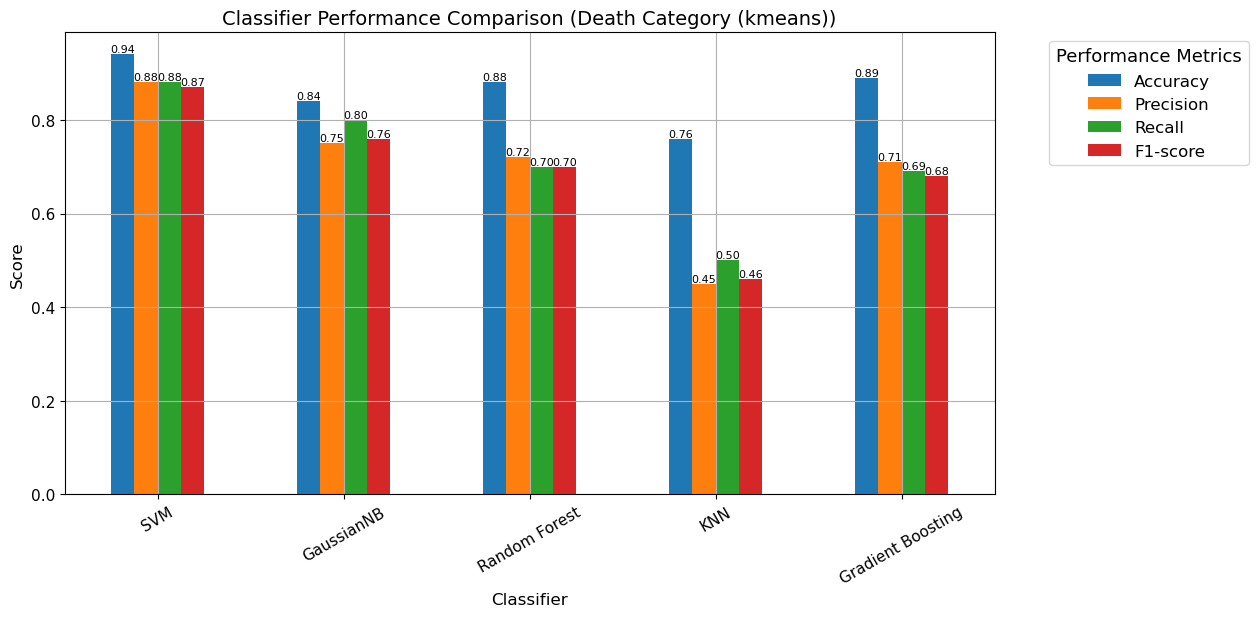

In [62]:
Kmeans_results_kfold = evaluate_classifier_kfold(filtered_df3, "Death Category (kmeans)", n_neighbors=2)

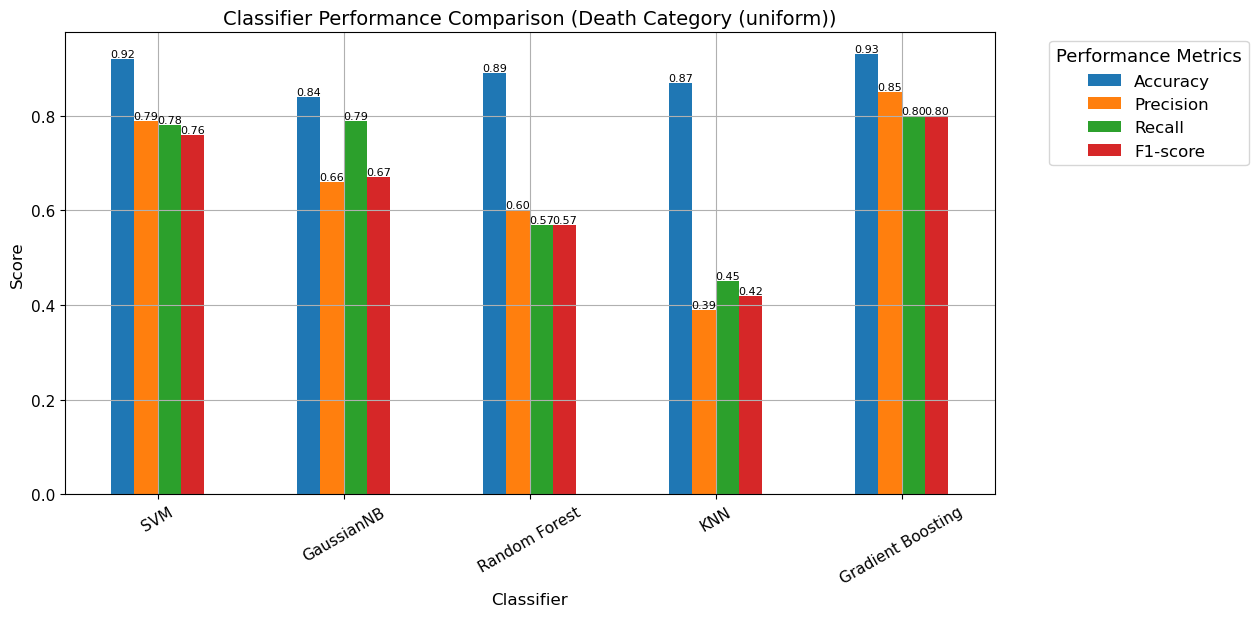

In [63]:
uniform_results_kfold = evaluate_classifier_kfold(filtered_df3, "Death Category (uniform)", n_neighbors=5)

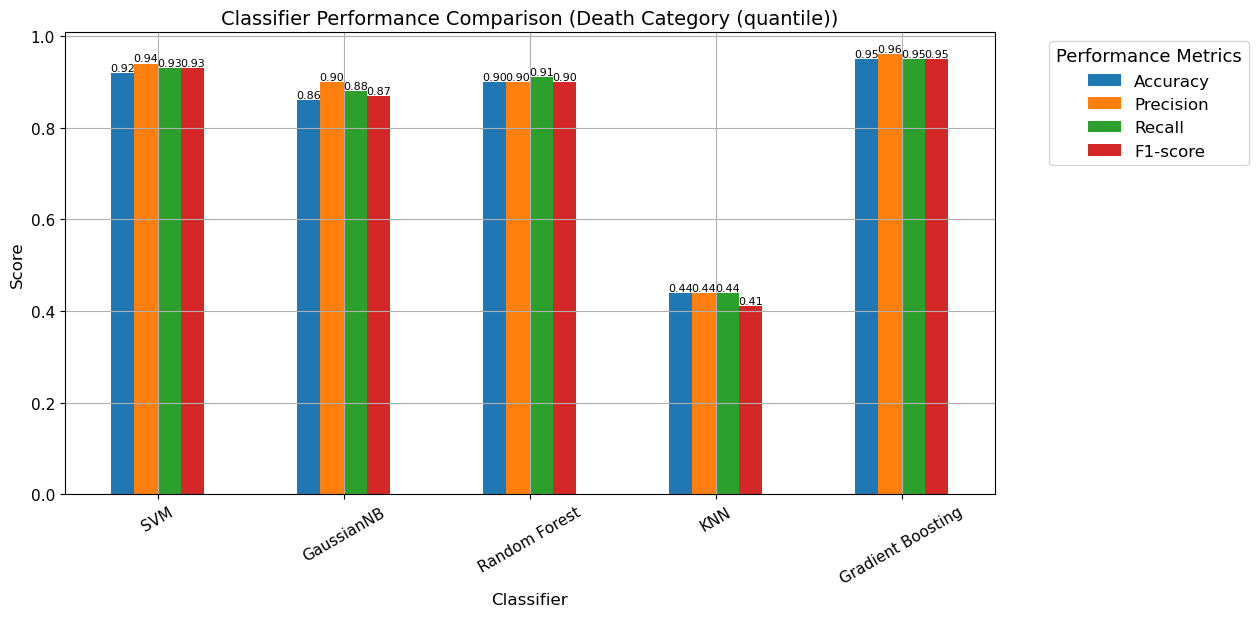

In [64]:
quantile_results_kfold = evaluate_classifier_kfold(filtered_df3, "Death Category (quantile)", n_neighbors=5)

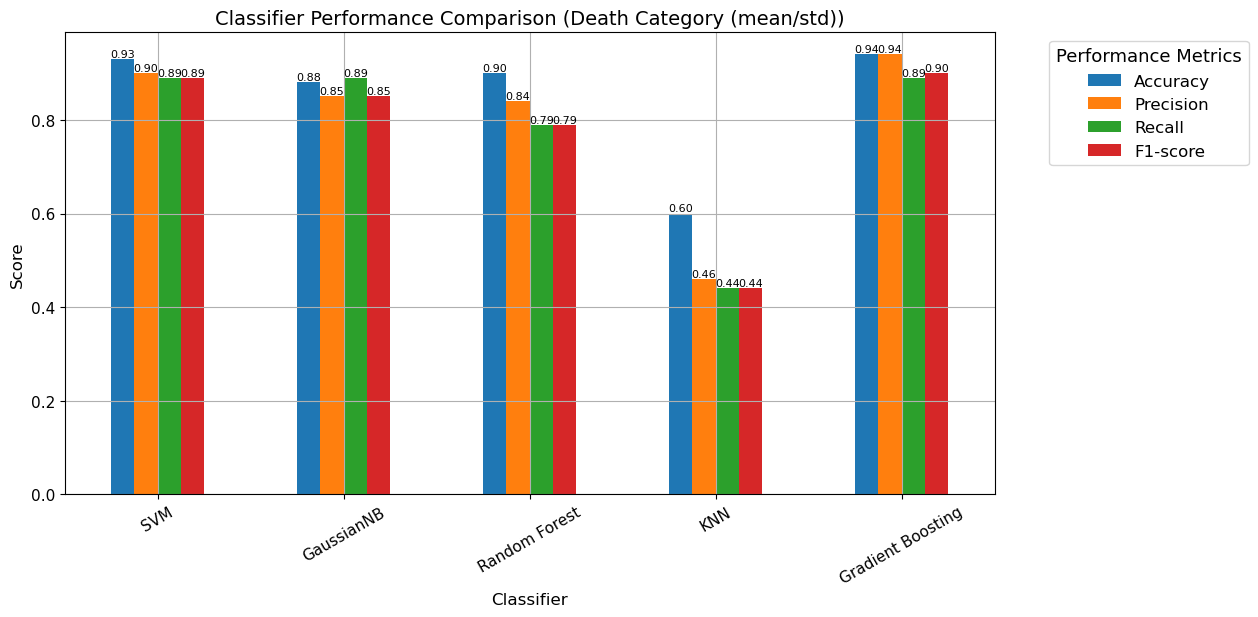

In [65]:
meanstd_results_kfold = evaluate_classifier_kfold(filtered_df3, "Death Category (mean/std)", n_neighbors=5)

#### Hyperparameters Tuning

In [66]:
def tune_classifier_kfold(df, y_var):
    # Use target labels as they exist
    X = df.iloc[:, :-5]
    y = df[y_var]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    classifiers = {
        "SVM": (SVC(probability=True), {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10, 100]}),
        "Random Forest": (RandomForestClassifier(),
                          {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10],
                           'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10]}),
        "Gradient Boosting": (GradientBoostingClassifier(),
                              {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1], 
                               'max_depth': [2, 4], 'min_samples_split': [5, 10],
                               'subsample': [0.6, 0.8, 1.0], 'max_features': ['sqrt', 0.5]})
    }

    best_models = {}
    best_params = {}

    # Hyperparameter tuning for each classifier using 10-fold CV
    for name, (clf, param_grid) in classifiers.items():
        grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=skf, n_jobs=-1)
        grid_search.fit(X, y)
        best_models[name] = grid_search.best_estimator_
        best_params[name] = grid_search.best_params_

    # Evaluate tuned classifiers using 10-fold CV
    results = []
    for name, tuned_clf in best_models.items():
        acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            tuned_clf.fit(X_train, y_train)
            y_pred = tuned_clf.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            prec_scores.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            rec_scores.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

        # Compute average metrics over 10 folds
        avg_acc = round(sum(acc_scores) / len(acc_scores), 2)
        avg_prec = round(sum(prec_scores) / len(prec_scores), 2)
        avg_rec = round(sum(rec_scores) / len(rec_scores), 2)
        avg_f1 = round(sum(f1_scores) / len(f1_scores), 2)

        results.append([name, avg_acc, avg_prec, avg_rec, avg_f1])

    # Store results in a DataFrame
    df_results = pd.DataFrame(results, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"])
    df_results.set_index("Classifier", inplace=True)

    return df_results, best_params

In [67]:
tune_classifier_kfold(filtered_df3, "Death Category (kmeans)")

(                   Accuracy  Precision  Recall  F1-score
 Classifier                                              
 SVM                    0.95       0.88    0.88      0.88
 Random Forest          0.90       0.71    0.72      0.70
 Gradient Boosting      0.92       0.76    0.80      0.76,
 {'SVM': {'C': 0.1, 'kernel': 'linear'},
  'Random Forest': {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 200},
  'Gradient Boosting': {'learning_rate': 0.1,
   'max_depth': 4,
   'max_features': 0.5,
   'min_samples_split': 5,
   'n_estimators': 200,
   'subsample': 0.8}})

In [68]:
tune_classifier_kfold(filtered_df3, "Death Category (uniform)")

(                   Accuracy  Precision  Recall  F1-score
 Classifier                                              
 SVM                    0.95       0.85    0.82      0.82
 Random Forest          0.89       0.53    0.53      0.52
 Gradient Boosting      0.92       0.76    0.75      0.73,
 {'SVM': {'C': 0.1, 'kernel': 'linear'},
  'Random Forest': {'max_depth': 5,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 50},
  'Gradient Boosting': {'learning_rate': 0.5,
   'max_depth': 2,
   'max_features': 0.5,
   'min_samples_split': 10,
   'n_estimators': 100,
   'subsample': 1.0}})

In [69]:
tune_classifier_kfold(filtered_df3, "Death Category (quantile)")

(                   Accuracy  Precision  Recall  F1-score
 Classifier                                              
 SVM                    0.92       0.94    0.93      0.93
 Random Forest          0.92       0.93    0.92      0.92
 Gradient Boosting      0.94       0.96    0.95      0.95,
 {'SVM': {'C': 1, 'kernel': 'linear'},
  'Random Forest': {'max_depth': 10,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 200},
  'Gradient Boosting': {'learning_rate': 0.1,
   'max_depth': 4,
   'max_features': 0.5,
   'min_samples_split': 10,
   'n_estimators': 100,
   'subsample': 1.0}})

In [70]:
tune_classifier_kfold(filtered_df3, "Death Category (mean/std)")

(                   Accuracy  Precision  Recall  F1-score
 Classifier                                              
 SVM                    0.93        0.9    0.89      0.89
 Random Forest          0.87        0.8    0.76      0.76
 Gradient Boosting      0.93        0.9    0.87      0.88,
 {'SVM': {'C': 1, 'kernel': 'linear'},
  'Random Forest': {'max_depth': None,
   'min_samples_leaf': 2,
   'min_samples_split': 5,
   'n_estimators': 100},
  'Gradient Boosting': {'learning_rate': 0.1,
   'max_depth': 4,
   'max_features': 0.5,
   'min_samples_split': 5,
   'n_estimators': 50,
   'subsample': 1.0}})

### Analysis on the Final Model - SVM (Kmeans)

In [71]:
df_svm = filtered_df3.copy()

In [72]:
# Drop unnecessary column
df_svm = df_svm.drop(columns = ["Total death", "Death Category (uniform)", "Death Category (quantile)", "Death Category (mean/std)"])

In [73]:
df_svm

,Immature,Adult,South West,Wales,West Midlands,South East,Yolk sac infection/ omphalitis,Red Mite,Neoplasm,Marek's Disease,...,Eggs Import (Million Dozen),Eggs Export (Million Dozen),Eggs RPI average price (per dozen),Month_sin,Days of frost East of England_lag6,PCA_Weather2,PCA_Weather3,PCA_Weather4,PCA_Weather5,Death Category (kmeans)
0,0,3,0,0,0,1,0,0,0,1,...,10.3,0.7,309,5.000000e-01,9.2,-1.825240,-1.363307,0.590886,0.306910,0
1,1,2,0,0,1,0,0,0,0,0,...,9.8,0.7,311,8.660254e-01,9.2,-5.759073,-1.072032,1.506746,-0.866313,0
2,0,2,0,2,0,0,0,0,1,0,...,12.9,0.8,311,1.000000e+00,9.2,-4.345198,0.206567,-1.935279,-0.527678,0
3,1,3,0,0,1,0,0,0,0,0,...,14.0,0.7,312,8.660254e-01,9.2,2.129038,3.831355,-0.624267,0.047142,1
4,2,0,0,0,2,0,0,0,0,0,...,15.2,0.8,312,5.000000e-01,9.2,-1.951656,1.029047,-1.264003,0.455468,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0,2,0,0,0,0,0,0,0,0,...,13.1,2.6,323,-8.660254e-01,2.3,0.191715,-2.419336,1.279577,1.186250,0
152,1,1,0,0,0,0,0,0,0,0,...,12.5,3.3,326,-1.000000e+00,1.4,4.835327,2.476487,0.099617,-1.862836,0
153,0,2,0,2,0,0,0,0,1,0,...,14.3,3.5,326,-8.660254e-01,0.6,1.674814,-0.731307,-0.753358,-1.170390,0
154,0,0,0,0,0,0,0,0,0,0,...,13.7,2.2,328,-5.000000e-01,0.0,-0.582046,-0.387324,-0.263992,-2.058433,0


#### Run classification again on the chosen SVM

In [74]:
def svm_classifier_kfold(df, y_var):
    # Use target labels as they exist
    X = df.iloc[:, :-1]
    y = df[y_var]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    classifiers = [
        ("SVM", SVC(kernel="linear", probability=True))
    ]

    results = []

    # Train and evaluate classifiers using 10-fold CV
    for name, clf in classifiers:
        acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            clf.fit(X_train, y_train)
            y_hat = clf.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_hat))
            prec_scores.append(precision_score(y_test, y_hat, average='macro', zero_division=0))
            rec_scores.append(recall_score(y_test, y_hat, average='macro', zero_division=0))
            f1_scores.append(f1_score(y_test, y_hat, average='macro', zero_division=0))

        # Compute average metrics across 10 folds
        avg_acc = round(sum(acc_scores) / len(acc_scores), 2)
        avg_prec = round(sum(prec_scores) / len(prec_scores), 2)
        avg_rec = round(sum(rec_scores) / len(rec_scores), 2)
        avg_f1 = round(sum(f1_scores) / len(f1_scores), 2)

        results.append([name, avg_acc, avg_prec, avg_rec, avg_f1])

    # Convert results to DataFrame
    df_results = pd.DataFrame(results, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"])
    df_results.set_index("Classifier", inplace=True)

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    df_results.plot(kind="bar", ax=ax, grid=True, rot=0)

    ax.legend(title="Performance Metrics", fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc="upper left")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, label_type="edge")

    ax.set_title(f"Classifier Performance Comparison ({y_var})", fontsize=14)
    ax.set_xlabel("Classifier", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.show()

    return df_results

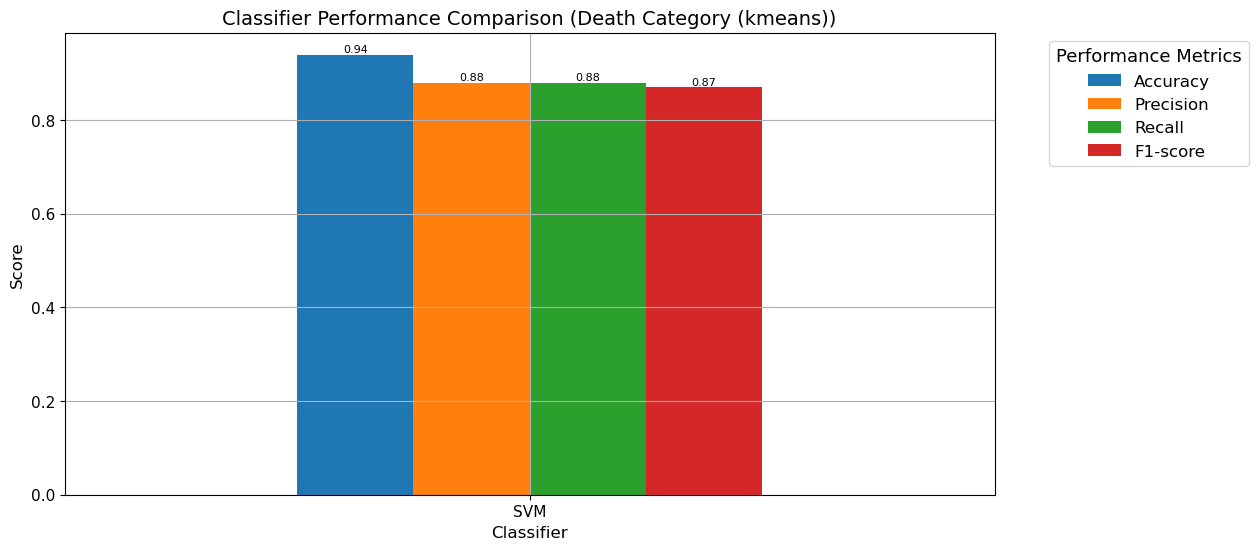

,Accuracy,Precision,Recall,F1-score
Classifier,,,,
SVM,0.94,0.88,0.88,0.87


In [75]:
svm_classifier_kfold(df_svm, "Death Category (kmeans)")

##### Per Class


Structured Classification Report:

            Low  Medium  High
Accuracy   0.96    0.94  0.99
Precision  0.97    0.88  0.50
Recall     0.97    0.88  0.50
F1-score   0.97    0.86  0.50


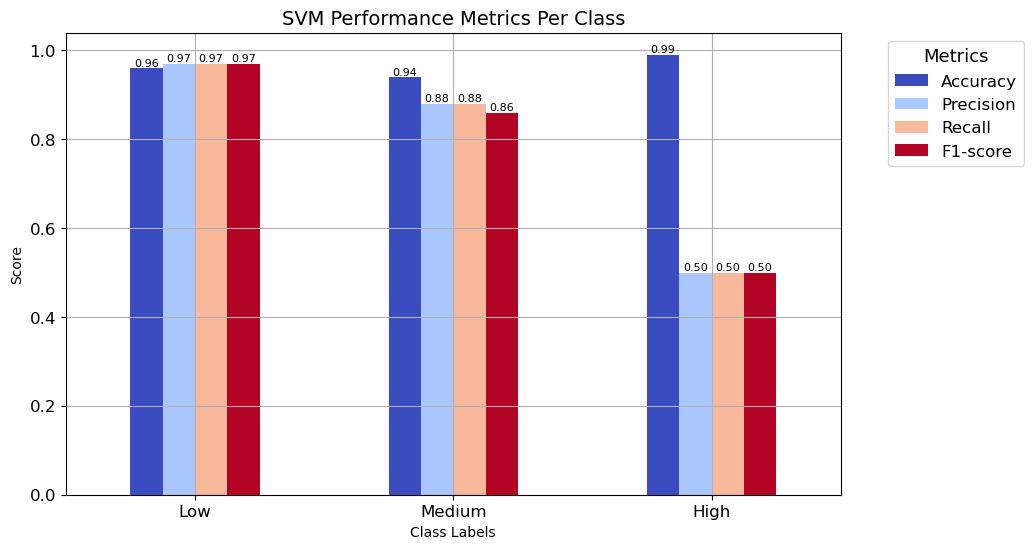

In [76]:
# Define features and target variable
X = df_svm.iloc[:, :-1]  # Assuming last column is the target
y = df_svm["Death Category (kmeans)"]

# Define class labels mapping
label_mapping = {0: "Low", 1: "Medium", 2: "High"}
class_names = ["Low", "Medium", "High"]  # Maintain the correct order for plotting

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
svm = SVC(kernel="linear", probability=True)

# Store per-class evaluation metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
class_scores = {label: {metric: [] for metric in metrics} for label in class_names}

# Perform 10-fold cross-validation
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    svm.fit(X_train, y_train)
    y_hat = svm.predict(X_test)

    # Compute per-class metrics
    for class_id, class_label in label_mapping.items():
        y_binary = (y_test == class_id).astype(int)  # Convert to binary for each class
        y_hat_binary = (y_hat == class_id).astype(int)

        class_scores[class_label]["Accuracy"].append(accuracy_score(y_binary, y_hat_binary))
        class_scores[class_label]["Precision"].append(precision_score(y_binary, y_hat_binary, zero_division=0))
        class_scores[class_label]["Recall"].append(recall_score(y_binary, y_hat_binary, zero_division=0))
        class_scores[class_label]["F1-score"].append(f1_score(y_binary, y_hat_binary, zero_division=0))

# Compute average metrics across folds
df_results = pd.DataFrame({label: [np.mean(class_scores[label][metric]) for metric in metrics] 
                           for label in class_names}, index=metrics).round(2)

# Print structured classification report
print("\nStructured Classification Report:\n")
print(df_results)

# Visualization: Side-by-side bar plot for each metric
fig, ax = plt.subplots(figsize=(10, 6))
df_results.T.plot(kind="bar", ax=ax, rot=0, grid=True, colormap="coolwarm")

ax.legend(title="Metrics", fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc="upper left")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=8, label_type="edge")

ax.set_title("SVM Performance Metrics Per Class", fontsize=14)
ax.set_xlabel("Class Labels")
ax.set_ylabel("Score")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

##### Hyperparameter Tuning

In [77]:
# Define features & target variable
X_svm = df_svm.drop(columns=["Death Category (kmeans)"])
y_svm = df_svm["Death Category (kmeans)"]  # No label encoding applied

# Set up stratified k-fold cross-validation
skf_svm = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Define SVM model & expanded hyperparameter grid
svm_model = SVC()

param_grid_svm = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 
     'shrinking': [True, False], 'class_weight': [None, 'balanced'], 'tol': [1e-3, 1e-4]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 
     'max_iter': [-1, 1000, 5000]}
]

# Perform hyperparameter tuning with GridSearchCV
grid_search_svm = GridSearchCV(
    svm_model, param_grid_svm, scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
    refit="accuracy", cv=skf_svm, n_jobs=-1, verbose=2
)
grid_search_svm.fit(X_svm, y_svm)

# Get best hyperparameters & create best SVM model
best_params_svm = grid_search_svm.best_params_
best_svm_model = SVC(**best_params_svm)

# Train the best SVM model on the full dataset
best_svm_model.fit(X_svm, y_svm)

# Save predictions into df_svm
df_svm["Predictive_Class_SVM"] = best_svm_model.predict(X_svm)

# Evaluate best SVM model with cross-validation
accuracy_list_svm, precision_list_svm, recall_list_svm, f1_list_svm = [], [], [], []

for train_idx, test_idx in skf_svm.split(X_svm, y_svm):
    X_train_svm, X_test_svm = X_svm.iloc[train_idx], X_svm.iloc[test_idx]
    y_train_svm, y_test_svm = y_svm.iloc[train_idx], y_svm.iloc[test_idx]

    best_svm_model.fit(X_train_svm, y_train_svm)
    y_pred_svm = best_svm_model.predict(X_test_svm)

    accuracy_list_svm.append(accuracy_score(y_test_svm, y_pred_svm))
    precision_list_svm.append(precision_score(y_test_svm, y_pred_svm, average="macro"))
    recall_list_svm.append(recall_score(y_test_svm, y_pred_svm, average="macro"))
    f1_list_svm.append(f1_score(y_test_svm, y_pred_svm, average="macro"))

print("\nBest Hyperparameters (SVM):", best_params_svm)
print("\nBest SVM Model Performance (10-Fold CV):")
print(f"Accuracy: {np.mean(accuracy_list_svm):.4f}")
print(f"Precision: {np.mean(precision_list_svm):.4f}")
print(f"Recall: {np.mean(recall_list_svm):.4f}")
print(f"F1-Score: {np.mean(f1_list_svm):.4f}")

# Display a preview of df_svm to confirm predictions are saved

Fitting 10 folds for each of 88 candidates, totalling 880 fits

Best Hyperparameters (SVM): {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear', 'max_iter': 5000}

Best SVM Model Performance (10-Fold CV):
Accuracy: 0.9546
Precision: 0.8846
Recall: 0.8899
F1-Score: 0.8832


##### Visualize the AUC-ROC curve

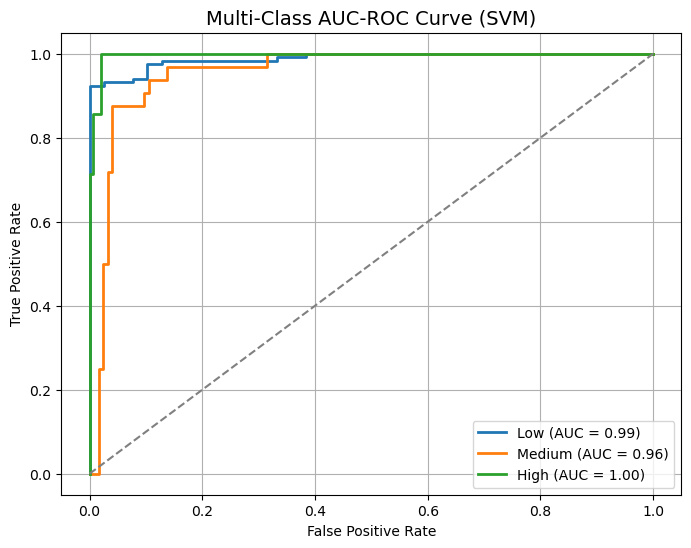

In [78]:
# Define features and target variable
X = df_svm.iloc[:, :-2] 
y = df_svm["Death Category (kmeans)"]

# Define class labels mapping
label_mapping = {0: "Low", 1: "Medium", 2: "High"}
classes = sorted(label_mapping.keys())  
y_bin = label_binarize(y, classes=classes)  

# Initialize Stratified K-Fold & SVM
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
svm = SVC(kernel="linear", probability=True) 

# Store predictions for AUC computation
all_y_true = []
all_y_prob = []

# Perform cross-validation
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    svm.fit(X_train, y_train)
    y_prob = svm.decision_function(X_test)  

    all_y_true.extend(y_test)
    all_y_prob.append(y_prob)

# Convert to NumPy array
all_y_prob = np.vstack(all_y_prob)

# Plot AUC-ROC curve for each class
fig, ax = plt.subplots(figsize=(8, 6))

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(label_binarize(all_y_true, classes=classes)[:, i], all_y_prob[:, i])
    auc_score = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{label_mapping[class_label]} (AUC = {auc_score:.2f})", lw=2)

# Diagonal reference line
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

ax.set_title("Multi-Class AUC-ROC Curve (SVM)", fontsize=14)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
ax.grid(True)

plt.show()

##### Confusion matrix

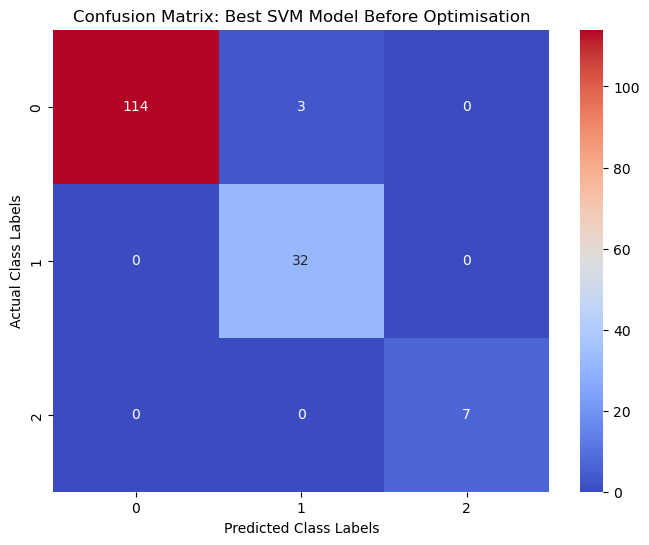

In [79]:
# Define actual & predicted class labels from df_svm
y_actual_svm = df_svm["Death Category (kmeans)"] 
y_pred_svm = df_svm["Predictive_Class_SVM"]  

# Compute confusion matrix
cm_svm = confusion_matrix(y_actual_svm, y_pred_svm)

# Extract unique class labels for display (ensuring sorted order for consistency)
class_labels_svm = sorted(df_svm["Death Category (kmeans)"].unique())

# Plot confusion matrix with heatmap (showing original class labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="coolwarm", xticklabels=class_labels_svm, yticklabels=class_labels_svm)

plt.xlabel("Predicted Class Labels")
plt.ylabel("Actual Class Labels")
plt.title("Confusion Matrix: Best SVM Model Before Optimisation")
plt.show()

#### Apply feature weight (importance) to keep the true weight of features


Top 20 Most Important Features (SVM):
 Absolute Weight                            Feature
        1.587722                           Immature
        1.519132                              Adult
        0.926149     Yolk sac infection/ omphalitis
        0.520408                      West Midlands
        0.295374                       PCA_Weather4
        0.267832        Eggs Import (Million Dozen)
        0.262864                       PCA_Weather5
        0.230900                    Marek's Disease
        0.224073                           Red Mite
        0.147112                              Wales
        0.091426                       PCA_Weather3
        0.091078                       PCA_Weather2
        0.083925                          Month_sin
        0.072034                         South West
        0.026488                         South East
        0.022040        Eggs Export (Million Dozen)
        0.014801 Days of frost East of England_lag6
        0.007622         

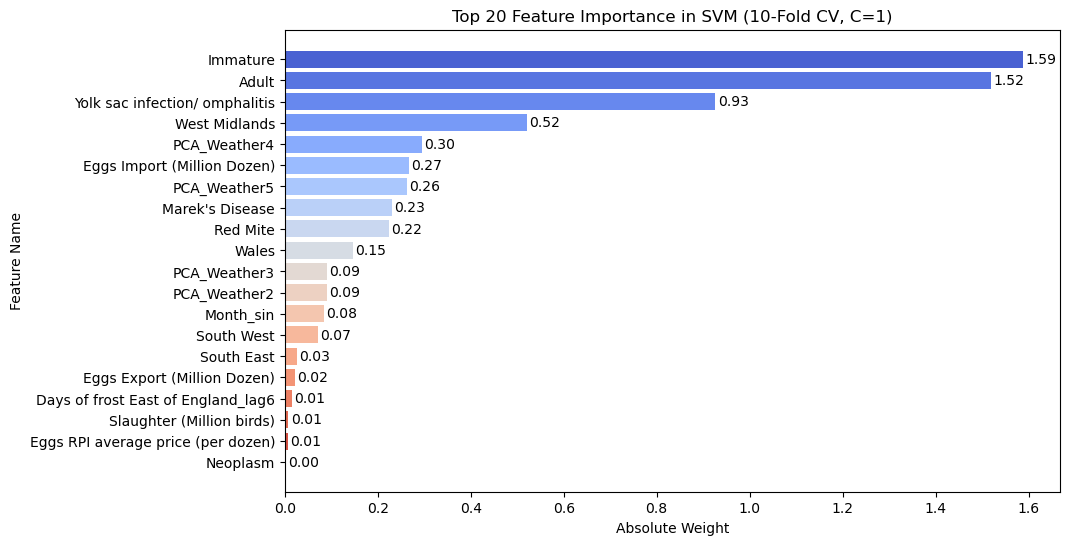

In [80]:
def svm_feature_importance(df, y_var, top_n=20):
    X = df.iloc[:, :-2]  
    y = df[y_var]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    svm = SVC(kernel="linear", probability=True)

    feature_weights = np.zeros(X.shape[1])  

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        svm.fit(X_train, y_train)
        feature_weights += svm.coef_[0]

    # Normalize weights across folds
    feature_weights /= skf.get_n_splits()

    # Extract & sort feature importance
    f_names = X.columns.tolist()
    sorted_features = sorted(zip(abs(feature_weights), f_names), reverse=True)[:top_n]

    # Convert to DataFrame
    df_importance = pd.DataFrame(sorted_features, columns=["Absolute Weight", "Feature"])
    
    # Print sorted feature importance
    print("\nTop {} Most Important Features (SVM):".format(top_n))
    print(df_importance.to_string(index=False))

    # Visualization
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("coolwarm", len(df_importance))
    
    bars = plt.barh(df_importance["Feature"], df_importance["Absolute Weight"], color=colors)
    
    # Add labels next to each bar
    for bar, weight in zip(bars, df_importance["Absolute Weight"]):
        plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f"{weight:.2f}", va="center", fontsize=10, color="black")
    
    plt.xlabel("Absolute Weight")
    plt.ylabel("Feature Name")
    plt.title("Top {} Feature Importance in SVM (10-Fold CV, C=1)".format(top_n))
    plt.gca().invert_yaxis() 
    plt.show()

    return df_importance

df_importance = svm_feature_importance(df_svm, "Death Category (kmeans)")

#### Apply forward feature selection

In [81]:
# Extract sorted features from feature importance analysis
ranked_features = df_importance["Feature"].tolist()

# Initialize feature tracking & accuracy measurement
optimal_feature_set = []
highest_accuracy = 0

# Prepare dataset
X_features = df_svm.drop(columns=["Death Category (kmeans)"])
y_target = df_svm["Death Category (kmeans)"]

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Forward selection loop
for candidate_feature in ranked_features:
    test_feature_set = optimal_feature_set + [candidate_feature] 
    
    accuracy_scores = []

    for train_idx, test_idx in strat_kfold.split(X_features, y_target):
        X_train_subset, X_test_subset = X_features.iloc[train_idx][test_feature_set], X_features.iloc[test_idx][test_feature_set]
        y_train_subset, y_test_subset = y_target.iloc[train_idx], y_target.iloc[test_idx]

        svm_model = SVC(kernel="linear")
        svm_model.fit(X_train_subset, y_train_subset)
        y_predicted = svm_model.predict(X_test_subset)

        accuracy_scores.append(accuracy_score(y_test_subset, y_predicted))

    avg_accuracy = round(sum(accuracy_scores) / len(accuracy_scores), 4)  

    print(f"Added: {candidate_feature}, Model Accuracy: {avg_accuracy}")

    # Retain feature if accuracy improves
    if avg_accuracy > highest_accuracy:
        optimal_feature_set.append(candidate_feature)
        highest_accuracy = avg_accuracy

print("\nOptimal Features Selected for Final Model:")
print(optimal_feature_set)

Added: Immature, Model Accuracy: 0.8653
Added: Adult, Model Accuracy: 0.9423
Added: Yolk sac infection/ omphalitis, Model Accuracy: 0.9808
Added: West Midlands, Model Accuracy: 0.9744
Added: PCA_Weather4, Model Accuracy: 0.9744
Added: Eggs Import (Million Dozen), Model Accuracy: 0.9742
Added: PCA_Weather5, Model Accuracy: 0.9744
Added: Marek's Disease, Model Accuracy: 0.9744
Added: Red Mite, Model Accuracy: 0.9808
Added: Wales, Model Accuracy: 0.9808
Added: PCA_Weather3, Model Accuracy: 0.9679
Added: PCA_Weather2, Model Accuracy: 0.9873
Added: Month_sin, Model Accuracy: 0.9873
Added: South West, Model Accuracy: 0.9873
Added: South East, Model Accuracy: 0.9873
Added: Eggs Export (Million Dozen), Model Accuracy: 0.9873
Added: Days of frost East of England_lag6, Model Accuracy: 0.9873
Added: Slaughter (Million birds), Model Accuracy: 0.9744
Added: Eggs RPI average price (per dozen), Model Accuracy: 0.9808
Added: Neoplasm, Model Accuracy: 0.9873

Optimal Features Selected for Final Model:


##### Visualization

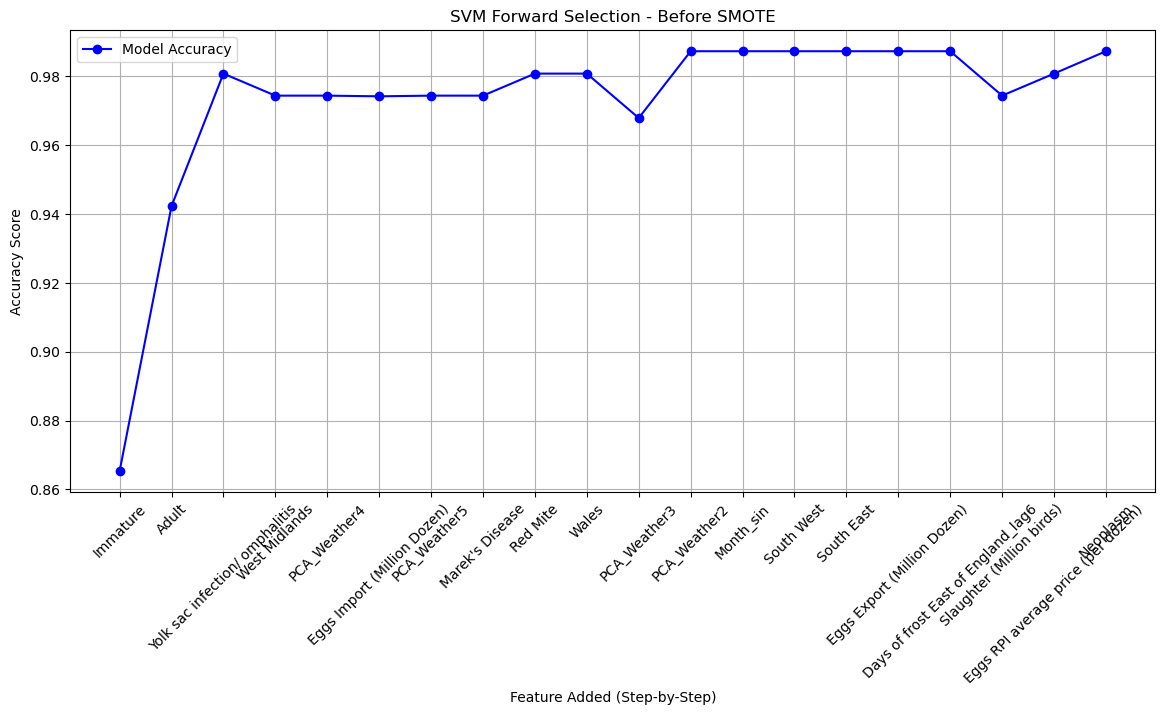

In [82]:
# Generate accuracy trend for each feature added
feature_evaluation_steps = []
accuracy_progress = []

optimal_feature_set = []
highest_accuracy = 0

for candidate_feature in ranked_features:
    test_feature_set = optimal_feature_set + [candidate_feature]

    accuracy_scores = []
    for train_idx, test_idx in strat_kfold.split(X_features, y_target):
        X_train_subset, X_test_subset = X_features.iloc[train_idx][test_feature_set], X_features.iloc[test_idx][test_feature_set]
        y_train_subset, y_test_subset = y_target.iloc[train_idx], y_target.iloc[test_idx]

        svm_model = SVC(kernel="linear")
        svm_model.fit(X_train_subset, y_train_subset)
        y_predicted = svm_model.predict(X_test_subset)

        accuracy_scores.append(accuracy_score(y_test_subset, y_predicted))

    avg_accuracy = round(sum(accuracy_scores) / len(accuracy_scores), 4)

    feature_evaluation_steps.append(candidate_feature)
    accuracy_progress.append(avg_accuracy)

    if avg_accuracy > highest_accuracy:
        optimal_feature_set.append(candidate_feature)
        highest_accuracy = avg_accuracy

# Plot accuracy trend during feature selection
plt.figure(figsize=(14, 6))
plt.plot(feature_evaluation_steps, accuracy_progress, marker="o", linestyle="-", color="b", label="Model Accuracy")

plt.xlabel("Feature Added (Step-by-Step)")
plt.ylabel("Accuracy Score")
plt.title("SVM Forward Selection - Before SMOTE")
plt.xticks(rotation=45)  # Ensure feature names are readable
plt.grid(True)
plt.legend()

plt.show()

#### APPLY SMOTE FOR BALANCING & TESTING

In [83]:
df_svm = df_svm.drop(columns = ['Predictive_Class_SVM'])

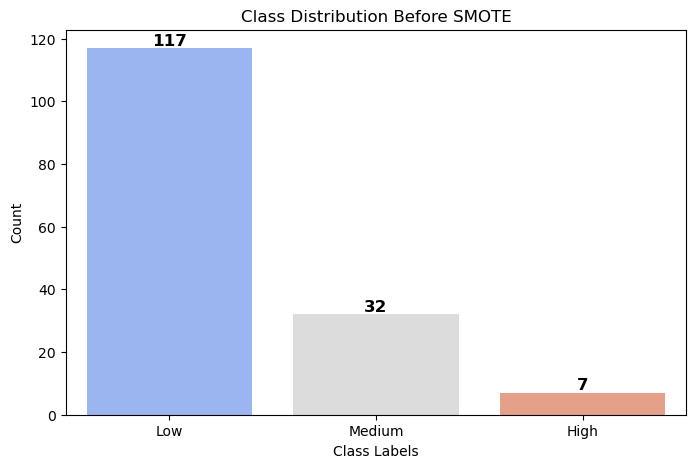

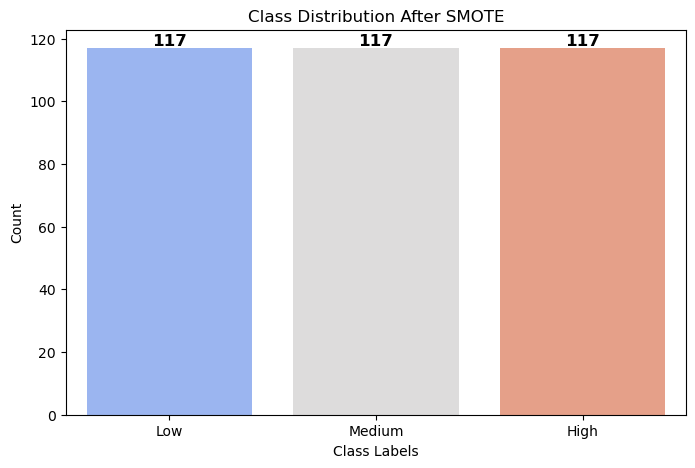

In [84]:
def balance_data_with_smote(df, response_var):

    # Define features and target variable
    X = df.drop(columns=[response_var]).astype(float)
    y = df[response_var] 

    # Define mapping for visualization
    label_mapping = {0: "Low", 1: "Medium", 2: "High"}

    def plot_class_distribution(y, title):
        plt.figure(figsize=(8, 5))

        # Apply mapping for visualization only, dataset remains unchanged
        ax = sns.countplot(x=y.map(label_mapping), palette="coolwarm")

        for p in ax.patches:
            ax.annotate(f"{int(p.get_height())}", 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

        plt.title(title)
        plt.xlabel("Class Labels")
        plt.ylabel("Count")
        plt.show()

    # Plot class distribution BEFORE SMOTE
    plot_class_distribution(y, "Class Distribution Before SMOTE")

    # Apply SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=0)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Create DataFrame while preserving numeric labels (0, 1, 2)
    balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
    balanced_df[response_var] = y_resampled  # Keep numeric labels intact

    # Plot class distribution AFTER SMOTE (visualization uses categorical labels)
    plot_class_distribution(y_resampled, "Class Distribution After SMOTE")

    return balanced_df

# Call function & visualize results
balanced_df = balance_data_with_smote(df_svm, "Death Category (kmeans)")

##### Correlation checking

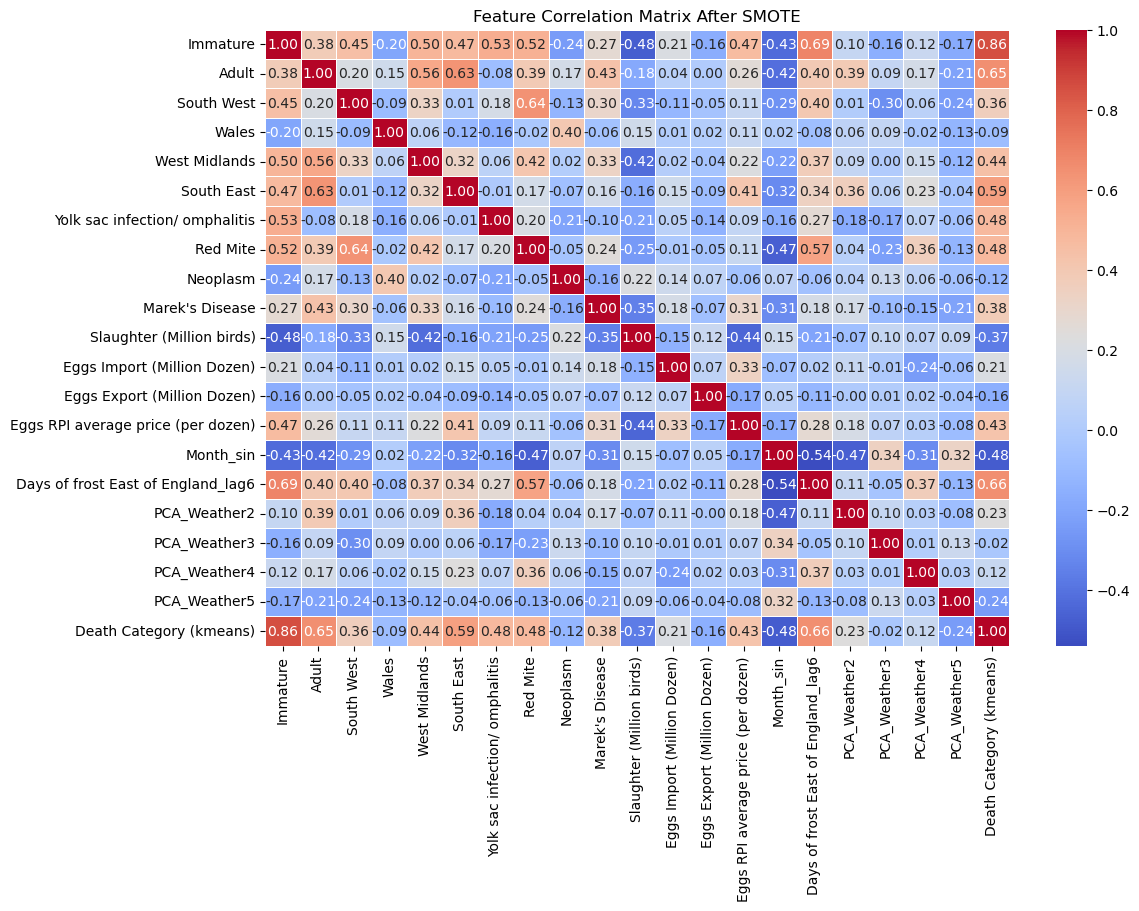

In [85]:
# Identify the last column in balanced_df
categorical_column = balanced_df.columns[-1]  

# Select only numerical columns for correlation calculation (excluding encoding)
numeric_df = balanced_df.select_dtypes(include=["number"])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Feature Correlation Matrix After SMOTE")
plt.show()

##### Remove features > 0.5, keep the ones that have high correlation with "Death Category (kmeans)" => final_df

In [86]:
# Compute correlation matrix for balanced_df
correlation_matrix = balanced_df.corr()

# Identify correlation threshold
threshold = 0.5

# Extract correlation values with the response variable
target_correlation = correlation_matrix["Death Category (kmeans)"].abs()

# Create a set to track features to remove
features_to_remove = set()

# Iterate through correlation matrix for explanatory variables only
explanatory_features = correlation_matrix.drop("Death Category (kmeans)", axis=1).drop("Death Category (kmeans)", axis=0)

for col in explanatory_features.columns:
    for row in explanatory_features.index:
        if col != row and row not in features_to_remove and col not in features_to_remove:
            if abs(explanatory_features.loc[row, col]) > threshold: 
                # Compare correlation strength with the response variable
                if target_correlation[row] < target_correlation[col]:  
                    features_to_remove.add(row)  # Remove the weaker correlated variable
                else:
                    features_to_remove.add(col)  # Remove the weaker correlated variable

# Drop identified features from the dataset
final_df = balanced_df.drop(columns=features_to_remove)

# Print removed features
print("\nRemoved Features Due to High Correlation:")
print(sorted(features_to_remove))

# Display remaining features
print("\nRemaining Features After Filtering:")
print(final_df.columns.tolist())


Removed Features Due to High Correlation:
['Days of frost East of England_lag6', 'Red Mite', 'South East', 'West Midlands', 'Yolk sac infection/ omphalitis']

Remaining Features After Filtering:
['Immature', 'Adult', 'South West', 'Wales', 'Neoplasm', "Marek's Disease", 'Slaughter (Million birds)', 'Eggs Import (Million Dozen)', 'Eggs Export (Million Dozen)', 'Eggs RPI average price (per dozen)', 'Month_sin', 'PCA_Weather2', 'PCA_Weather3', 'PCA_Weather4', 'PCA_Weather5', 'Death Category (kmeans)']


##### Run Classification Model AFTER SMOTE and correlation removal

In [87]:
def svm_classifier_kfold(df, y_var):
    # Use target labels as they exist
    X = df.iloc[:, :-1]
    y = df[y_var]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    classifiers = [
        ("SVM", SVC(kernel="linear", probability=True))
    ]

    results = []

    # Train and evaluate classifiers using 10-fold CV
    for name, clf in classifiers:
        acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            clf.fit(X_train, y_train)
            y_hat = clf.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_hat))
            prec_scores.append(precision_score(y_test, y_hat, average='macro', zero_division=0))
            rec_scores.append(recall_score(y_test, y_hat, average='macro', zero_division=0))
            f1_scores.append(f1_score(y_test, y_hat, average='macro', zero_division=0))

        # Compute average metrics across 10 folds
        avg_acc = round(sum(acc_scores) / len(acc_scores), 2)
        avg_prec = round(sum(prec_scores) / len(prec_scores), 2)
        avg_rec = round(sum(rec_scores) / len(rec_scores), 2)
        avg_f1 = round(sum(f1_scores) / len(f1_scores), 2)

        results.append([name, avg_acc, avg_prec, avg_rec, avg_f1])

    # Convert results to DataFrame
    df_results = pd.DataFrame(results, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"])
    df_results.set_index("Classifier", inplace=True)

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    df_results.plot(kind="bar", ax=ax, grid=True, rot=0)

    ax.legend(title="Performance Metrics", fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc="upper left")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, label_type="edge")

    ax.set_title(f"SVM Performance After SMOTE and Correlation ({y_var})", fontsize=14)
    ax.set_xlabel("Classifier", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.show()

    return df_results

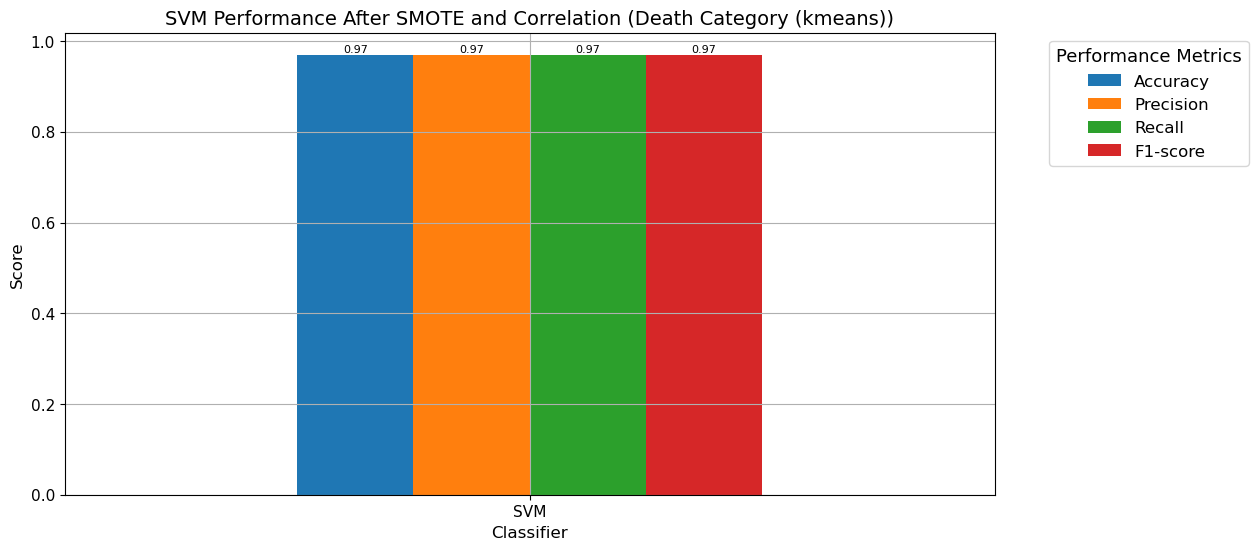

,Accuracy,Precision,Recall,F1-score
Classifier,,,,
SVM,0.97,0.97,0.97,0.97


In [88]:
svm_classifier_kfold(final_df, "Death Category (kmeans)")

##### Visualize the AUC-ROC curve AFTER SMOTE & Correlation removal

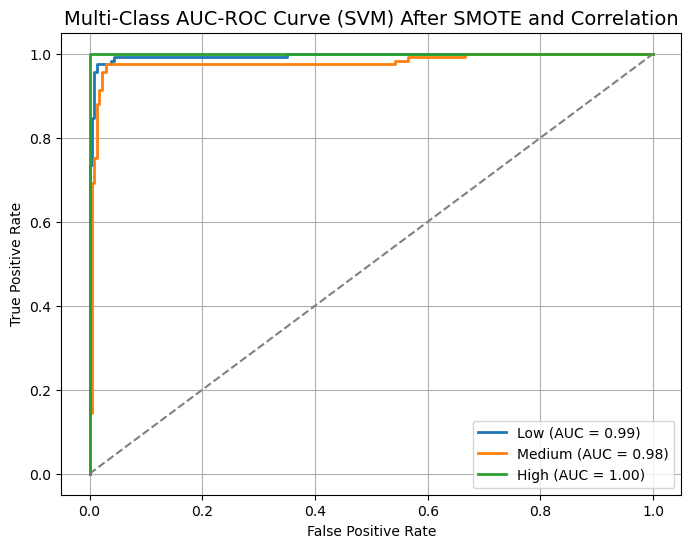

In [89]:
# Define features and target variable
X = final_df.iloc[:, :-1]  # Assuming last column is the target
y = final_df["Death Category (kmeans)"]

# Define class labels mapping
label_mapping = {0: "Low", 1: "Medium", 2: "High"}
classes = sorted(label_mapping.keys())  
y_bin = label_binarize(y, classes=classes)  

# Initialize Stratified K-Fold & SVM
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
svm = SVC(kernel="linear", probability=True) 

# Store predictions for AUC computation
all_y_true = []
all_y_prob = []

# Perform cross-validation
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    svm.fit(X_train, y_train)
    y_prob = svm.decision_function(X_test)  

    all_y_true.extend(y_test)
    all_y_prob.append(y_prob)

# Convert to NumPy array
all_y_prob = np.vstack(all_y_prob)

# Plot AUC-ROC curve for each class
fig, ax = plt.subplots(figsize=(8, 6))

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(label_binarize(all_y_true, classes=classes)[:, i], all_y_prob[:, i])
    auc_score = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{label_mapping[class_label]} (AUC = {auc_score:.2f})", lw=2)

# Diagonal reference line
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

ax.set_title("Multi-Class AUC-ROC Curve (SVM) After SMOTE and Correlation", fontsize=14)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
ax.grid(True)

plt.show()

##### Feature weight (importance) for SVM


Top 14 Most Important Features (SVM):
 Absolute Weight                            Feature
        2.186170                           Immature
        1.386449                              Adult
        0.633304                    Marek's Disease
        0.470310                       PCA_Weather4
        0.361039                       PCA_Weather5
        0.358491        Eggs Import (Million Dozen)
        0.221241                              Wales
        0.186435                         South West
        0.130394        Eggs Export (Million Dozen)
        0.128871                       PCA_Weather2
        0.078978                           Neoplasm
        0.077287                          Month_sin
        0.038401                       PCA_Weather3
        0.011571 Eggs RPI average price (per dozen)


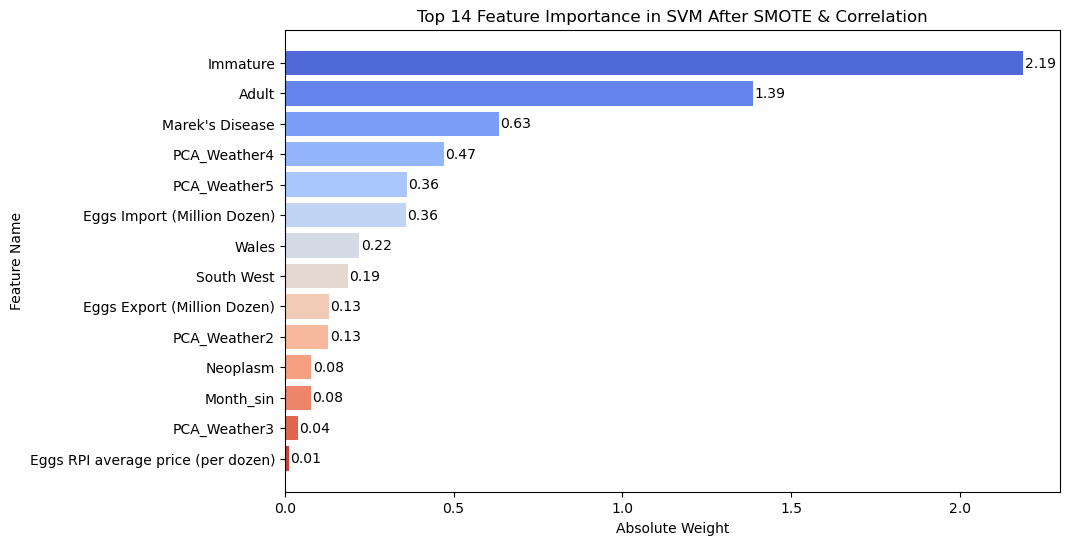

In [90]:
def svm_feature_importance(df, y_var, top_n=14):
    X = df.iloc[:, :-1]  
    y = df[y_var]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    svm = SVC(kernel="linear", probability=True)

    feature_weights = np.zeros(X.shape[1])  

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        svm.fit(X_train, y_train)
        feature_weights += svm.coef_[0]

    # Normalize weights across folds
    feature_weights /= skf.get_n_splits()

    # Extract & sort feature importance
    f_names = X.columns.tolist()
    sorted_features = sorted(zip(abs(feature_weights), f_names), reverse=True)[:top_n]

    # Convert to DataFrame
    df_importance = pd.DataFrame(sorted_features, columns=["Absolute Weight", "Feature"])
    
    # Print sorted feature importance
    print("\nTop {} Most Important Features (SVM):".format(top_n))
    print(df_importance.to_string(index=False))

    # Visualization
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("coolwarm", len(df_importance))
    
    bars = plt.barh(df_importance["Feature"], df_importance["Absolute Weight"], color=colors)
    
    # Add labels next to each bar
    for bar, weight in zip(bars, df_importance["Absolute Weight"]):
        plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f"{weight:.2f}", va="center", fontsize=10, color="black")
    
    plt.xlabel("Absolute Weight")
    plt.ylabel("Feature Name")
    plt.title("Top {} Feature Importance in SVM After SMOTE & Correlation".format(top_n))
    plt.gca().invert_yaxis() 
    plt.show()

    return df_importance

df_importance = svm_feature_importance(final_df, "Death Category (kmeans)")

##### Feature selection AFTER SMOTE AND CORRELATION

In [91]:
# Extract sorted features from feature importance analysis
sorted_features = df_importance["Feature"].tolist()

# Initialize feature set & accuracy tracker
selected_features = []
best_accuracy = 0

# Prepare data
X = final_df.drop(columns=["Death Category (kmeans)"])
y = final_df["Death Category (kmeans)"]

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Forward selection loop
for feature in sorted_features:
    temp_features = selected_features + [feature]  # Add new feature
    
    acc_scores = []  # Track accuracy across folds

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx][temp_features], X.iloc[test_idx][temp_features]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        svm = SVC(kernel="linear")
        svm.fit(X_train, y_train)
        y_hat = svm.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_hat))

    avg_acc = round(sum(acc_scores) / len(acc_scores), 4)  # Compute average accuracy

    print(f"Added: {feature}, Model Accuracy: {avg_acc}")

    # Keep feature if accuracy improves
    if avg_acc > best_accuracy:
        selected_features.append(feature)
        best_accuracy = avg_acc

print("\nSelected Features for Final Model:")
print(selected_features)

Added: Immature, Model Accuracy: 0.7889
Added: Adult, Model Accuracy: 0.9658
Added: Marek's Disease, Model Accuracy: 0.9687
Added: PCA_Weather4, Model Accuracy: 0.9829
Added: PCA_Weather5, Model Accuracy: 0.9801
Added: Eggs Import (Million Dozen), Model Accuracy: 0.9801
Added: Wales, Model Accuracy: 0.9801
Added: South West, Model Accuracy: 0.9801
Added: Eggs Export (Million Dozen), Model Accuracy: 0.9801
Added: PCA_Weather2, Model Accuracy: 0.9829
Added: Neoplasm, Model Accuracy: 0.9801
Added: Month_sin, Model Accuracy: 0.9829
Added: PCA_Weather3, Model Accuracy: 0.9858
Added: Eggs RPI average price (per dozen), Model Accuracy: 0.9717

Selected Features for Final Model:
['Immature', 'Adult', "Marek's Disease", 'PCA_Weather4', 'PCA_Weather3']


##### Perform forward selection AFTER SMOTE AND CORRELATION

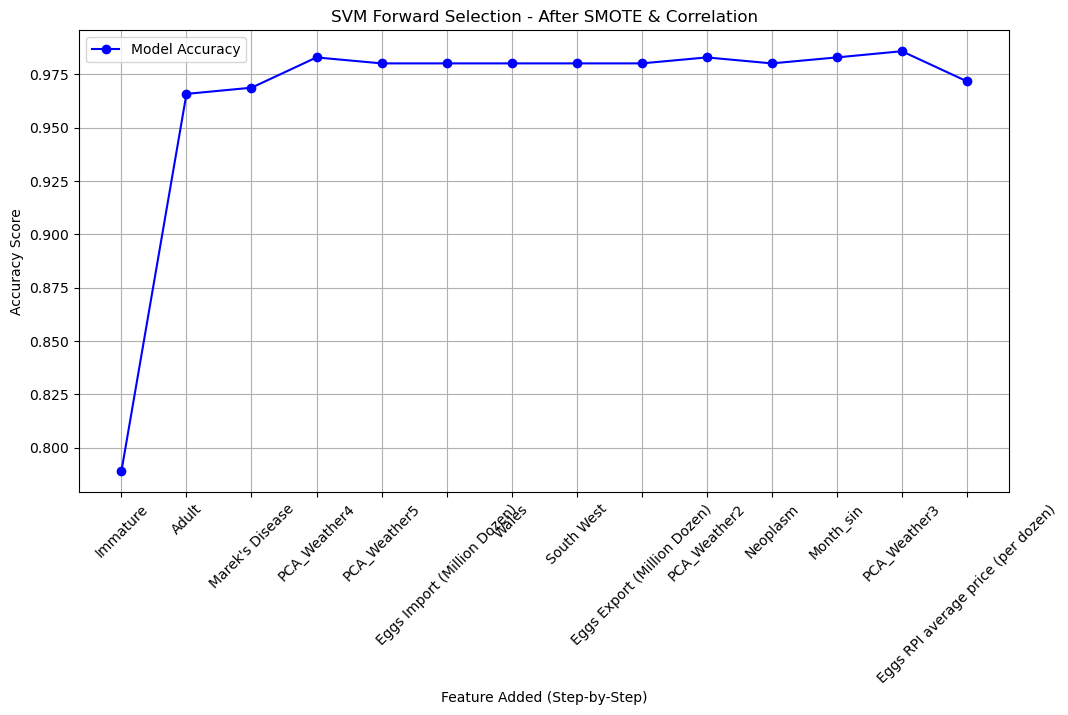

In [92]:
# Generate accuracy trend for each feature added
feature_steps = []
accuracy_trend = []

selected_features = []
best_accuracy = 0

for feature in sorted_features:
    temp_features = selected_features + [feature]

    acc_scores = []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx][temp_features], X.iloc[test_idx][temp_features]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        svm = SVC(kernel="linear")
        svm.fit(X_train, y_train)
        y_hat = svm.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_hat))

    avg_acc = round(sum(acc_scores) / len(acc_scores), 4)

    feature_steps.append(feature)
    accuracy_trend.append(avg_acc)

    if avg_acc > best_accuracy:
        selected_features.append(feature)
        best_accuracy = avg_acc

# Plot line graph
plt.figure(figsize=(12, 6))
plt.plot(feature_steps, accuracy_trend, marker="o", linestyle="-", color="b", label="Model Accuracy")

plt.xlabel("Feature Added (Step-by-Step)")
plt.ylabel("Accuracy Score")
plt.title("SVM Forward Selection - After SMOTE & Correlation")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.show()

##### Hyperparameter Tuning AFTER SMOTE and Correlation

In [93]:
# Define features & target variable
X = final_df.drop(columns=["Death Category (kmeans)"])
y = final_df["Death Category (kmeans)"]  # No label encoding applied

# Set up stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Define SVM model & expanded hyperparameter grid
svm = SVC()

param_grid = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 
     'shrinking': [True, False], 'class_weight': [None, 'balanced'], 'tol': [1e-3, 1e-4]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 
     'max_iter': [-1, 1000, 5000]}
]

# Perform hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(
    svm, param_grid, scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
    refit="accuracy", cv=skf, n_jobs=-1, verbose=2
)
grid_search.fit(X, y)

# Get best hyperparameters & create best SVM model
best_params = grid_search.best_params_
best_svm = SVC(**best_params)

# Train the best SVM model on the full dataset
best_svm.fit(X, y)

# Save predictions into final_df
final_df["Predictive_Class"] = best_svm.predict(X)

# Evaluate best SVM model with cross-validation
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_svm.fit(X_train, y_train)
    y_pred = best_svm.predict(X_test)

    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, average="macro"))
    recall_list.append(recall_score(y_test, y_pred, average="macro"))
    f1_list.append(f1_score(y_test, y_pred, average="macro"))

print("\nBest Hyperparameters:", best_params)
print("\nBest SVM Model Performance (10-Fold CV):")
print(f"Accuracy: {np.mean(accuracy_list):.4f}")
print(f"Precision: {np.mean(precision_list):.4f}")
print(f"Recall: {np.mean(recall_list):.4f}")
print(f"F1-Score: {np.mean(f1_list):.4f}")

# Display a preview of final_df to confirm predictions are saved
print("\nUpdated final_df with Predictive_Class:")

Fitting 10 folds for each of 88 candidates, totalling 880 fits

Best Hyperparameters: {'C': 10, 'class_weight': None, 'kernel': 'linear', 'max_iter': -1}

Best SVM Model Performance (10-Fold CV):
Accuracy: 0.9830
Precision: 0.9843
Recall: 0.9828
F1-Score: 0.9829

Updated final_df with Predictive_Class:


##### Confusion Matrix AFTER SMOTE and Correlation

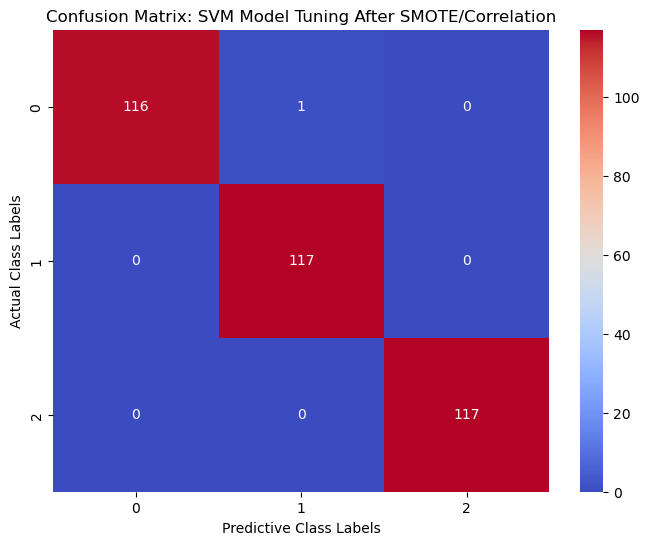

In [94]:
# Define actual & predicted class labels from final_df
y_actual = final_df["Death Category (kmeans)"]  # True labels
y_pred = final_df["Predictive_Class"]  # Predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_actual, y_pred)

# Extract unique class labels for display (ensuring sorted order for consistency)
class_labels = sorted(final_df["Death Category (kmeans)"].unique())

# Plot confusion matrix with heatmap (showing original class labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predictive Class Labels")
plt.ylabel("Actual Class Labels")
plt.title("Confusion Matrix: SVM Model Tuning After SMOTE/Correlation")
plt.show()

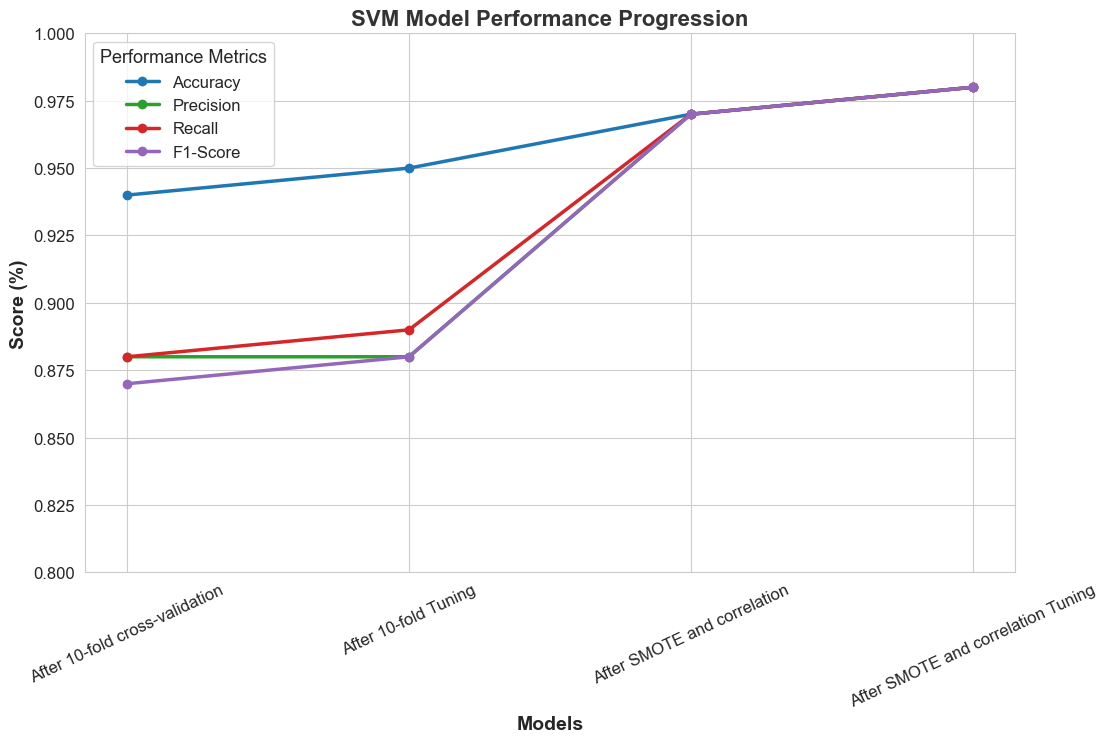

In [100]:
def plot_normal_metrics(names, accuracies, precisions, recalls, f1_scores):
    """Creates a clean line graph for SVM model performance across different evaluation metrics."""
    
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    colors = ["#1f77b4", "#2ca02c", "#d62728", "#9467bd"]  

    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")

    x_positions = np.arange(len(names))  
    # Plot each metric separately using solid lines
    for metric, color, values in zip(metrics, colors, [accuracies, precisions, recalls, f1_scores]):
        plt.plot(x_positions, values, marker="o", linestyle="-", linewidth=2.5, color=color, label=metric)

    # Formatting axes and labels
    plt.xticks(x_positions, names, fontsize=12, rotation=25)
    plt.xlabel("Models", fontsize=14, fontweight="bold")
    plt.ylabel("Score (%)", fontsize=14, fontweight="bold")
    plt.title("SVM Model Performance Progression", fontsize=16, fontweight="bold", color="#333333")
    plt.yticks(fontsize=12)
    plt.ylim(0.8, 1)
    # Add a clear legend for metrics
    plt.legend(title="Performance Metrics", fontsize=12, title_fontsize=13, loc="best", frameon=True)

    # Show the graph
    plt.show()

# Example usage
plot_normal_metrics(
    names=["After 10-fold cross-validation", "After 10-fold Tuning", "After SMOTE and correlation","After SMOTE and correlation Tuning"],
    accuracies=[0.94, 0.95, 0.97, 0.98],
    precisions=[0.88, 0.88, 0.97, 0.98],
    recalls=[0.88, 0.89, 0.97, 0.98],
    f1_scores=[0.87, 0.88, 0.97, 0.98]
)

In [101]:
import pandas as pd

# Define data
names = ["After 10-fold cross-validation", "After 10-fold Tuning", 
         "After SMOTE and correlation", "After SMOTE and correlation Tuning"]
accuracies = [0.94, 0.95, 0.97, 0.98]
precisions = [0.88, 0.88, 0.97, 0.98]
recalls = [0.88, 0.89, 0.97, 0.98]
f1_scores = [0.87, 0.88, 0.97, 0.98]

# Create DataFrame
df = pd.DataFrame({
    "Method": names,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1-Score": f1_scores
})

# Display DataFrame
print(df)

                               Method  Accuracy  Precision  Recall  F1-Score
0      After 10-fold cross-validation      0.94       0.88    0.88      0.87
1                After 10-fold Tuning      0.95       0.88    0.89      0.88
2         After SMOTE and correlation      0.97       0.97    0.97      0.97
3  After SMOTE and correlation Tuning      0.98       0.98    0.98      0.98
